In [1]:
from params import *
from Dataset import get_dataloader
from Model import SKModel

import numpy as np
import pandas as pd

import IPython
import matplotlib.pyplot as plt
import matplotlib.backend_bases as mpl

%matplotlib widget
import seaborn as sns

import os
import shutil
import glob
import time
import sys

import re
import pretty_midi
import librosa

from sklearn.linear_model import SGDRegressor, Perceptron, LogisticRegression
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LearningCurveDisplay, train_test_split
from sklearn.metrics import classification_report, accuracy_score

import torch
import torchaudio

from mido import MidiFile


%load_ext autoreload
%autoreload 2


# Looking at our data

### Metadata

In [2]:
mid = pretty_midi.PrettyMIDI('data/musicnet_midis/Schubert/1727_schubert_op114_2.mid')
mid.instruments

[Instrument(program=40, is_drum=False, name="Violin"),
 Instrument(program=41, is_drum=False, name="Viola"),
 Instrument(program=42, is_drum=False, name="Cello"),
 Instrument(program=43, is_drum=False, name="Contrabass"),
 Instrument(program=0, is_drum=False, name="Pianoforte")]

In [3]:
meta = pd.read_csv(r"data\musicnet_metadata.csv")
meta.head(3)

id  composer               composition                   movement  \
0  1727  Schubert  Piano Quintet in A major                 2. Andante   
1  1728  Schubert  Piano Quintet in A major         3. Scherzo: Presto   
2  1729  Schubert  Piano Quintet in A major  4. Andantino - Allegretto   

        ensemble            source                      transcriber  \
0  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
1  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
2  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   

  catalog_name  seconds  
0        OP114      447  
1        OP114      251  
2        OP114      444

In [4]:
meta = meta.drop(columns=["composition","movement", "ensemble", "source", "transcriber", "catalog_name"])
meta.head(5)

id  composer  seconds
0  1727  Schubert      447
1  1728  Schubert      251
2  1729  Schubert      444
3  1730  Schubert      368
4  1733  Schubert      546

In [5]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        330 non-null    int64 
 1   composer  330 non-null    object
 2   seconds   330 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ KB


### Sound files

AudioMetaData(sample_rate=44100, num_frames=19715328, num_channels=1, bits_per_sample=32, encoding=PCM_F)
number of features: 19715328


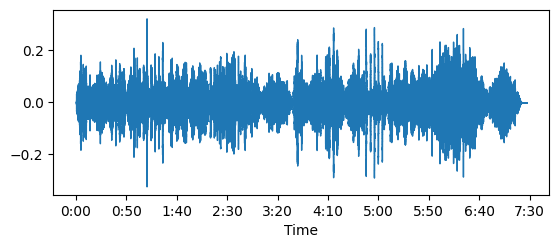

In [6]:
samples1,sr1 = torchaudio.load(AUDIO_EXAMPLE_PATH)

print(torchaudio.info(AUDIO_EXAMPLE_PATH))
print("number of features: {}".format(len(samples1[0])))

fig, ax1 = plt.subplots(1,figsize=(6.4,2.4))
librosa.display.waveshow(y=samples1.numpy(),sr=sr1,ax=ax1)
plt.close()
fig

We take only a sample of the initial audio file and reduce the sampling rate to get a dramatic decrease in number of features

number of features 1: 220500, number of features 2: 40000


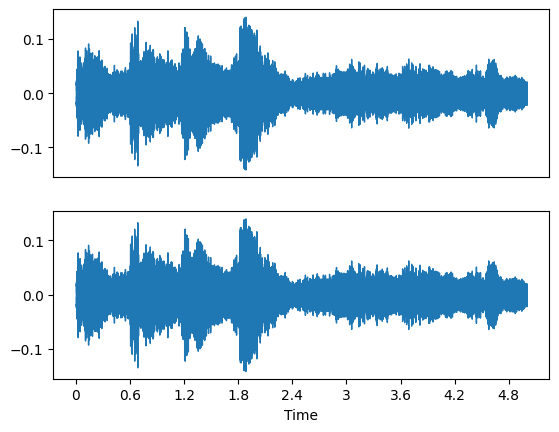

In [7]:
#Sample from second 8
samples1,sr1 = torchaudio.load(AUDIO_EXAMPLE_PATH, frame_offset=AUDIO_EXAMPLE_OFFSET_SEC*sr1,num_frames=SAMPLE_LENGTH*sr1)
samples2 = torchaudio.functional.resample(samples1,sr1,SAMPLING_RATE)

print("number of features 1: {}, number of features 2: {}".format(len(samples1[0]),len(samples2[0])))

fig, (ax1,ax2) = plt.subplots(2,1)
librosa.display.waveshow(y=samples1.numpy(),sr=sr1,ax=ax1,axis=None)
librosa.display.waveshow(y=samples2.numpy(),sr=SAMPLING_RATE,ax=ax2)
plt.close()
fig

In [8]:
IPython.display.display(IPython.display.Audio(samples1,rate=sr1))
IPython.display.display(IPython.display.Audio(samples2,rate=SAMPLING_RATE))


We lose some audio quality but really not that much!

# Creating our dataset

run this cell once

In [9]:
#Move the files to the desired directory
def create_dataset(df:pd.DataFrame):
    samples = {sample[:-4]:"train" for sample in  os.listdir('data/musicnet/train_data')}
    samples.update({sample[:-4]:"test" for sample in  os.listdir('data/musicnet/test_data')})
    
    instrument_data = []
    
    for path in glob.glob('data/musicnet_midis/*/*.mid'):
        id = re.sub("_.*","",os.path.basename(path))
        if id in samples:
            #keep only samples where we can access the midi file
            try: 
                mid = pretty_midi.PrettyMIDI(path)

                #load and save wav files as tensors
                sample_data,sr = torchaudio.load(f"data/musicnet/{samples[id]}_data/{id}.wav")
                sample_data = torchaudio.functional.resample(sample_data,sr,SAMPLING_RATE)
                torch.save(sample_data,f'data\{samples[id]}\{id}.pt')


                #Create instrument labels
                label = {"id":int(id), "path":f'data\{samples[id]}\{id}.pt', "train":samples[id]=="train"}
                label.update({instrument.program:1 for instrument in  mid.instruments})
                instrument_data.append(label)

            #remove "bad" samples
            except:
                print(f"could not load file: {path}")
                shutil.move(f"data/musicnet/{samples[id]}_data/{id}.wav",f"data/bad_data/{samples[id]}_data/{id}.wav")

    instrument_df = pd.DataFrame.from_records(instrument_data)
    return df.merge(instrument_df, on="id",how="right")

#Create the new metadata only if it doesnt exists
if os.path.exists(RAW_LABELS_CSV_DIR) == False:
    df = create_dataset(meta)
    df.to_csv(RAW_LABELS_CSV_DIR,index=False)

df = pd.read_csv(RAW_LABELS_CSV_DIR)

## Data labeling

In [10]:
df = df[df["train"]]
df = df.drop(columns="train").reset_index(drop=True)
df.head(5)

id composer  seconds                path   40   41    0  73  42   6  45  \
0  2186     Bach      214  data\train\2186.pt  1.0  1.0  NaN NaN NaN NaN NaN   
1  2195     Bach      155  data\train\2195.pt  NaN  NaN  1.0 NaN NaN NaN NaN   
2  2196     Bach       75  data\train\2196.pt  NaN  NaN  1.0 NaN NaN NaN NaN   
3  2198     Bach      197  data\train\2198.pt  NaN  NaN  1.0 NaN NaN NaN NaN   
4  2200     Bach      113  data\train\2200.pt  NaN  NaN  1.0 NaN NaN NaN NaN   

   71  70  60  68  43  
0 NaN NaN NaN NaN NaN  
1 NaN NaN NaN NaN NaN  
2 NaN NaN NaN NaN NaN  
3 NaN NaN NaN NaN NaN  
4 NaN NaN NaN NaN NaN

setting NaN values to 0

In [11]:
FIRST_COLS = ["id", "composer", "seconds", "path"]
def populate_dataset(df:pd.DataFrame):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    df = df.fillna(0)
    df = df.loc[:,  FIRST_COLS + numerical_cols]
    df = df.set_index("id")
    
    return df 

df = populate_dataset(df)
df.head(5)

composer  seconds                path    0   40   41   42   43   45    6  \
id                                                                              
2186     Bach      214  data\train\2186.pt  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
2195     Bach      155  data\train\2195.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2196     Bach       75  data\train\2196.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2198     Bach      197  data\train\2198.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2200     Bach      113  data\train\2200.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

       60   68   70   71   73  
id                             
2186  0.0  0.0  0.0  0.0  0.0  
2195  0.0  0.0  0.0  0.0  0.0  
2196  0.0  0.0  0.0  0.0  0.0  
2198  0.0  0.0  0.0  0.0  0.0  
2200  0.0  0.0  0.0  0.0  0.0

In [12]:
def plot_data_dis(df,fig,ax1,ax2):
    def onPick(event:mpl.PickEvent):
        numerical_cols = list(df.columns.difference(FIRST_COLS))
        
        if event.mouseevent.button != 1:
            return
       
        patches = ax1.get_children()
        for p in patches:
            if p.properties()["picker"] == 5:
                p.remove()
                
        patches = ax2.get_children()
        for p in patches:
            if p.properties()["picker"] == 5:
                p.remove()
                
        
        
        num = int(np.rint(event.mouseevent.xdata))
        if event.mouseevent.inaxes.get_title() == "Composer distribution":
            if num in range(len(ax2_x)):
                y = df[df['composer']==ax2_x.index[num]][numerical_cols].sum()
                y = y[y>0]
                info = ["{}\n{:.2%}".format(v,v/ax1_y[k]) for k,v in y.items() ]
                p = ax1.bar(y.index,y,label=ax2_x.index[num],picker=5)
                ax1.bar_label(p,label_type='center',labels=info,picker=5)

                
                p = ax2.bar(ax2_x.index[num],ax2_y[ax2_x.index[num]],label=ax2_x.index[num],picker=5)
                
        else:
            if num in range(len(numerical_cols)):
                
                
                y = df[numerical_cols][df[numerical_cols[num]] == 1].sum()
                y = y[y>0]
                info = ["{}\n{:.2%}".format(v,v/ax1_y[k]) for k,v in y.items() ]
                p = ax1.bar(y.index,y,label=numerical_cols[num],picker=5)
                ax1.bar_label(p,label_type='center',labels=info,picker=5)

                y = df[df[numerical_cols[num]] == 1]['composer'].value_counts().astype(int)
                info = ["{}\n{:.2%}".format(v,v/ax2_y[k]) for k,v in y.items() ]
                p = ax2.bar(y.index,y,label=numerical_cols[num],picker=5)
                ax2.bar_label(p,label_type='center',labels=info,picker=5)
            
    
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    ax1_x = (df[numerical_cols].sum()*0+1).cumsum()-1
    ax1_y = df[numerical_cols].sum()
    p = ax1.bar(ax1_x.index, ax1_y,picker=True)
    ax1.bar_label(p,fmt=lambda h: "{}\n{:.2%}".format(int(h),h/len(df)))

    ax1.set_xticks(ax1_x)
    ax1.set_xticklabels(ax1_x.index)
    ax1.set_title("Instrument occurrences")
    ax1.set_ylabel("# Samples")
    ax1.set_xlabel("Instrument number")


    ax2_x = (df.composer.value_counts()*0 + 1).cumsum()-1
    ax2_y = df.composer.value_counts()
    ax2.bar(ax2_x.index, ax2_y,picker=True)
    for i, h in enumerate(ax2_y):
        ax2.text(i,h,h, horizontalalignment='center',va='bottom')
    x_labels = ax2_x.index
    
    ax2.set_xticks(ax2_x)
    ax2.set_xticklabels(x_labels)
    ax2.set_ylabel("# Samples")
    ax2.set_xlabel("Composer")
    ax2.set_title("Composer distribution")
    
    fig.canvas.mpl_connect('pick_event',onPick)
    return ax1,ax2



Try clicking on instruments

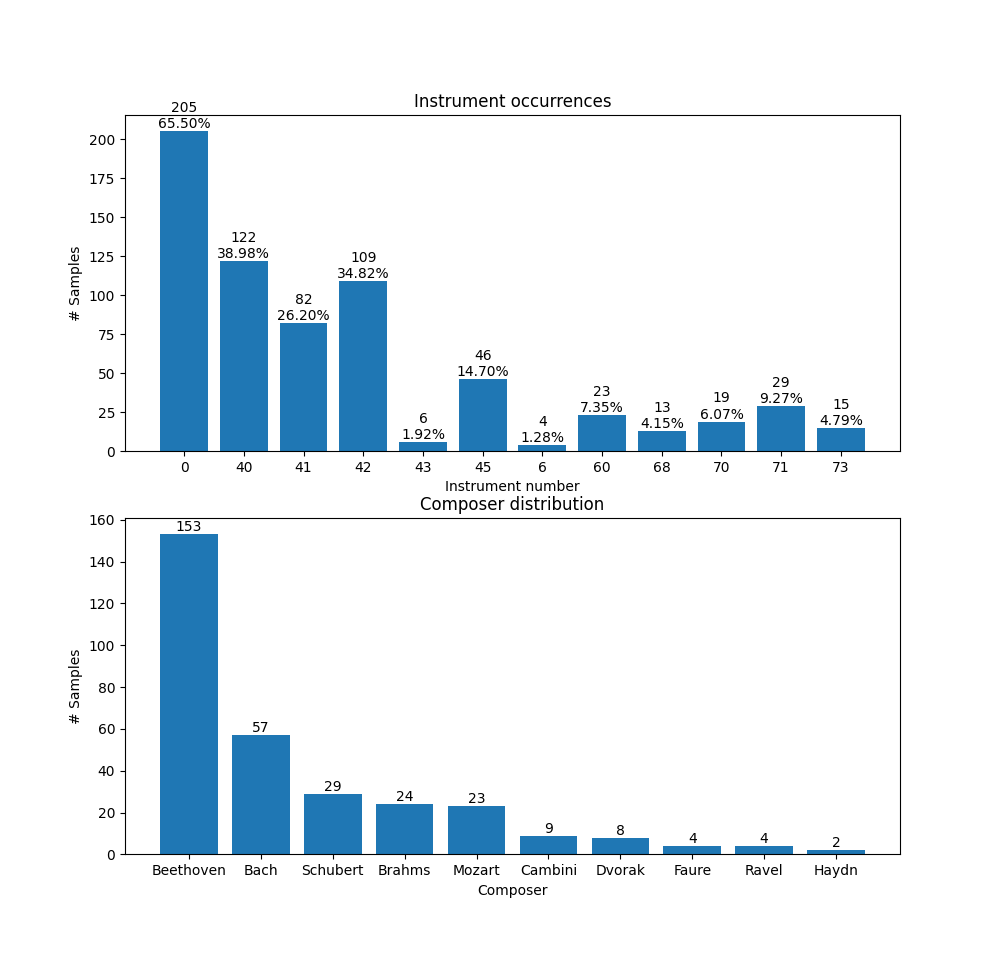

In [13]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,9.6))
ax1, ax2 = plot_data_dis(df,fig,ax1,ax2)
plt.show()

### Cleaning Data

Removing labels that have a low amount of samples

In [14]:
def remove_outliers(df,min_instrument=10, min_composer=5, iters=5):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    drop_composers = []
    for _ in range(iters):
        mask = (df[numerical_cols].sum() < min_instrument) &  (df[numerical_cols].sum() != 0)
        drop1 = mask[mask==True].index
        for i in drop1:
            df = df[df[i]!=1]

        mask = (df.composer.value_counts()<min_composer)
        drop2 = mask[mask==True].index
        
        if len(drop1)==0 and len(drop2)==0: 
            break

        for i in drop2:
            df = df[df["composer"] != i]
            drop_composers.append(i)

    
    mask = (df[numerical_cols].sum() == 0) 
    drop_instruments = mask[mask==True].index
    df = df.drop(columns=drop_instruments)
    return df, drop_instruments, drop_composers

Setting a hard limit on the number of samples in the dataset

Note: during training and testing each one label may correspond to multiple samples from the same audio file

In [15]:
def drop_excess_samples(df):
    while df['composer'].value_counts().max()-MAX_COMPOSER_SAMPLES > 0:
        composer_samples = df[df['composer']==df['composer'].value_counts().idxmax()]
        n = df['composer'].value_counts().max()-MAX_COMPOSER_SAMPLES
        df = df.drop(index=composer_samples.sample(n).index)
    return df

Ensure we have the same number of composers for a more accurate evaluation

In [16]:
def balance_composers(df):
    max_samples = MAX_COMPOSER_SAMPLES
    temp = df['composer'].value_counts() < max_samples
    for comp in temp.index:
        n = max_samples-df['composer'].value_counts()[comp]
        if n > 0:
            composer_samples = df[df['composer']==comp]
            df = pd.concat([df, composer_samples.sample(n,replace=True)])
    return df

In [17]:
df, drop_instruments, drop_composers = remove_outliers(df)
df = drop_excess_samples(df)
df = balance_composers(df)
df

composer  seconds                path    0   40   41   42   45   60   68  \
id                                                                              
2186     Bach      214  data\train\2186.pt  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
2195     Bach      155  data\train\2195.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2196     Bach       75  data\train\2196.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2198     Bach      197  data\train\2198.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2200     Bach      113  data\train\2200.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
...       ...      ...                 ...  ...  ...  ...  ...  ...  ...  ...   
1916   Dvorak      675  data\train\1916.pt  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
1922   Dvorak      402  data\train\1922.pt  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
1916   Dvorak      675  data\train\1916.pt  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
1923   Dvorak      393  data\train\1923.pt  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
1931   Dvorak      471  data\train\1931.pt  0.0  1.0  1.0  1.0  1.0  0.0  0.0   

       70   71   73  
id                   
2186  0.0  0.0  0.0  
2195  0.0  0.0  0.0  
2196  0.0  0.0  0.0  
2198  0.0  0.0  0.0  
2200  0.0  0.0  0.0  
...   ...  ...  ...  
1916  0.0  0.0  0.0  
1922  0.0  0.0  0.0  
1916  0.0  0.0  0.0  
1923  0.0  0.0  0.0  
1931  0.0  0.0  0.0  

[1050 rows x 13 columns]

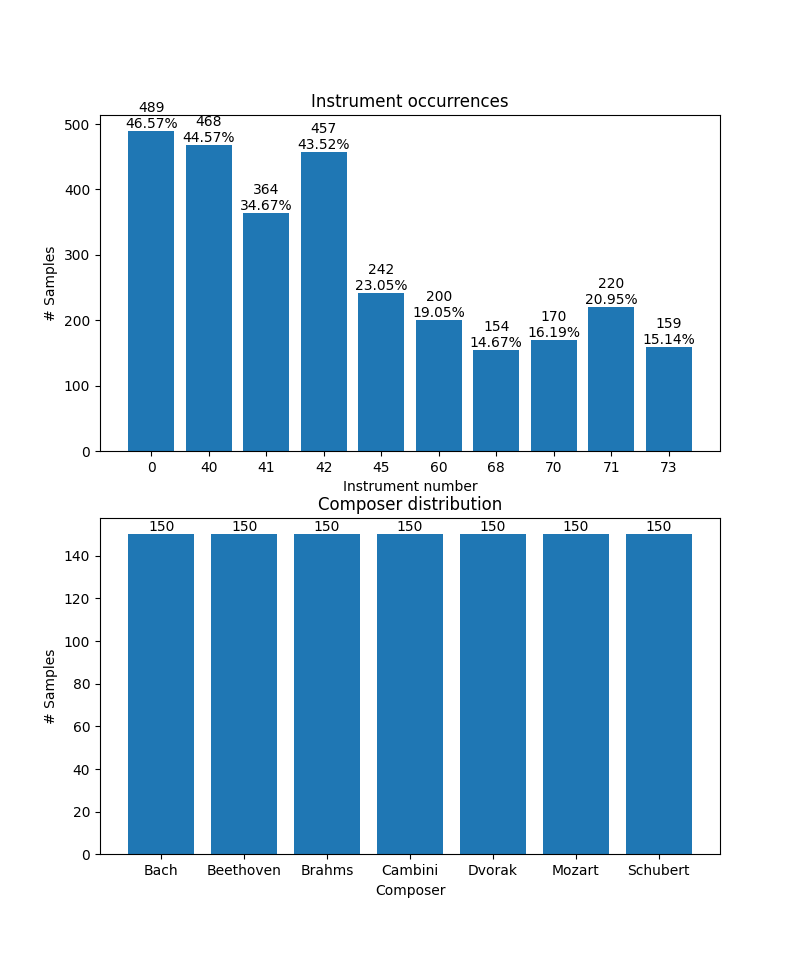

In [18]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,9.6))
ax1, ax2 = plot_data_dis(df,fig,ax1,ax2)
plt.show()

In [19]:
df.nunique()

composer      7
seconds     237
path        290
0             2
40            2
41            2
42            2
45            2
60            2
68            2
70            2
71            2
73            2
dtype: int64

## Test set

Since the test set from kaggle is small we will ensure the testing set has at least one sample from each class

In [20]:
def modify_test(test_df:pd.DataFrame,train_df:pd.DataFrame,drop_composers,drop_instruments,sample_train=1):
    
    for comp in drop_composers:
        test_df = test_df[test_df["composer"] != comp]
    for inst in drop_instruments:
        test_df = test_df[test_df[inst] != 1]
    test_df = test_df.drop(columns=drop_instruments)


    #Test is quite small so we artificially create more samples by taking away from train
    numerical_cols = np.sort(train_df.columns.difference(FIRST_COLS)).tolist()
    #ensure at least 1 sample from each class
    a = train_df.groupby(numerical_cols,group_keys=False)[train_df.columns].apply(lambda df: df.sample(sample_train),include_groups=True)
    b = train_df.groupby('composer',group_keys=False)[train_df.columns].apply(lambda df: df.sample(sample_train),include_groups=True)
    test_df = pd.concat([test_df,a,b]).drop_duplicates()
    train_df = train_df.drop(pd.concat([a,b]).index)
    return test_df,train_df
    

In [21]:
def load_data():
    
    if os.path.exists(RAW_LABELS_CSV_DIR) == False:
        df = create_dataset(meta)
        df.to_csv(RAW_LABELS_CSV_DIR)
    df = pd.read_csv(RAW_LABELS_CSV_DIR)
    train_df = df[df["train"]==True].drop(columns="train").reset_index(drop=True)
    test_df =  df[df["train"]==False].drop(columns="train").reset_index(drop=True)
    
    train_df = populate_dataset(train_df)
    test_df = populate_dataset(test_df)

    train_df,drop_instruments,drop_composers = remove_outliers(train_df)
    test_df,train_df = modify_test(test_df,train_df,drop_composers,drop_instruments)
    print("Test size:",len(test_df))
    
    
    train_df = drop_excess_samples(train_df)
    print('"Unique" train samples:',len(train_df))
    train_df = balance_composers(train_df)
    print("Total train size:",len(train_df))
    

    le = LabelEncoder()
    train_df["composer"] = le.fit_transform(train_df["composer"])
    test_df["composer"] = le.transform(test_df["composer"])
    return train_df, test_df

train_df,test_df =  load_data()

Test size: 38
"Unique" train samples: 264
Total train size: 1050


In [22]:
def getClasses(df):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    return [[0,1] for i in range(len(numerical_cols)) ], df.composer.unique()

INSTRUMENT_CLASSES, COMPOSER_CLASSES = getClasses(train_df)

# Data loading
### Train - Val split

In [23]:
X = train_df.path.to_numpy()
Y = train_df
test_x = test_df.path.to_numpy()
test_y = test_df

train_x, val_x, train_y, val_y = train_test_split(X,Y,test_size=SPLIT_SIZE,random_state=42)

In [24]:
train_x.shape, val_x.shape, test_x.shape

((630,), (420,), (38,))

We will be using pytorch's dataloader to load batches of data, for more info go to dataset.py

## Benchmarking

In [25]:
def mean_time(epoches,loader):
    total_time = 0
    total_samples = 0
    total_batches = 0
    for i in range(epoches):
        num_samples = 0
        num_batches = 0
        total_epoch_time = 0
        sample = torch.zeros(1)
        start = time.time()
        for s in loader:
            sample_time = time.time() - start
            
            sample = s[0]
            total_epoch_time += sample_time
            num_samples += len(s[0])
            num_batches += 1
            start = time.time()

        total_batches += num_batches
        total_samples += num_samples
        total_time += total_epoch_time

        avg_batch_time = total_epoch_time/num_batches
        avg_sample_time = total_epoch_time/num_samples
        print("Device: {}, Total run time for epoch {}: {:.4f}, Average batch load time: {:.5f}, Average sample load time: {:.6f}".format(sample.device,i,total_epoch_time,avg_batch_time,avg_sample_time))

    avg_epoch_time = total_time/epoches
    avg_sample_time = total_time/total_samples
    avg_batch_time = total_time/total_batches
    print("--------------------------------------------------------------------")
    print("Total run time for {} epoches: {:.3f}, Average epoch time: {:.4f}, Average batch load time: {:.5f}, Average sample load time: {:.6f}".format(epoches,total_time,avg_epoch_time,avg_batch_time,avg_sample_time))


In [26]:
train_ds,train_loader = get_dataloader(train_x,train_y,64,mode=0)
mean_time(10,train_loader)
del train_ds
del train_loader

Device: cpu, Total run time for epoch 0: 2.5995, Average batch load time: 0.25995, Average sample load time: 0.004126
Device: cpu, Total run time for epoch 1: 2.4115, Average batch load time: 0.24115, Average sample load time: 0.003828
Device: cpu, Total run time for epoch 2: 2.4765, Average batch load time: 0.24765, Average sample load time: 0.003931
Device: cpu, Total run time for epoch 3: 2.3508, Average batch load time: 0.23508, Average sample load time: 0.003731
Device: cpu, Total run time for epoch 4: 2.4360, Average batch load time: 0.24360, Average sample load time: 0.003867
Device: cpu, Total run time for epoch 5: 2.3915, Average batch load time: 0.23915, Average sample load time: 0.003796
Device: cpu, Total run time for epoch 6: 2.4665, Average batch load time: 0.24665, Average sample load time: 0.003915
Device: cpu, Total run time for epoch 7: 2.4080, Average batch load time: 0.24080, Average sample load time: 0.003822
Device: cpu, Total run time for epoch 8: 2.2675, Average

In [27]:
train_ds,train_loader = get_dataloader(train_x,Y,64,mode=0,cache_size=400)
mean_time(10,train_loader)
del train_ds
del train_loader

Device: cpu, Total run time for epoch 0: 4.1230, Average batch load time: 0.41230, Average sample load time: 0.006544
Device: cpu, Total run time for epoch 1: 0.9995, Average batch load time: 0.09995, Average sample load time: 0.001587
Device: cpu, Total run time for epoch 2: 1.1064, Average batch load time: 0.11064, Average sample load time: 0.001756
Device: cpu, Total run time for epoch 3: 0.9745, Average batch load time: 0.09745, Average sample load time: 0.001547
Device: cpu, Total run time for epoch 4: 0.9990, Average batch load time: 0.09990, Average sample load time: 0.001586
Device: cpu, Total run time for epoch 5: 1.0100, Average batch load time: 0.10100, Average sample load time: 0.001603
Device: cpu, Total run time for epoch 6: 1.1045, Average batch load time: 0.11045, Average sample load time: 0.001753
Device: cpu, Total run time for epoch 7: 1.0850, Average batch load time: 0.10850, Average sample load time: 0.001722
Device: cpu, Total run time for epoch 8: 0.9980, Average

In [28]:
train_ds,train_loader = get_dataloader(train_x,Y,64,mode=0,preload=True)
mean_time(10,train_loader)
del train_ds
del train_loader

Device: cpu, Total run time for epoch 0: 0.2575, Average batch load time: 0.02575, Average sample load time: 0.000409
Device: cpu, Total run time for epoch 1: 0.2380, Average batch load time: 0.02380, Average sample load time: 0.000378
Device: cpu, Total run time for epoch 2: 0.2020, Average batch load time: 0.02020, Average sample load time: 0.000321
Device: cpu, Total run time for epoch 3: 0.2370, Average batch load time: 0.02370, Average sample load time: 0.000376
Device: cpu, Total run time for epoch 4: 0.2205, Average batch load time: 0.02205, Average sample load time: 0.000350
Device: cpu, Total run time for epoch 5: 0.2465, Average batch load time: 0.02465, Average sample load time: 0.000391
Device: cpu, Total run time for epoch 6: 0.2420, Average batch load time: 0.02420, Average sample load time: 0.000384
Device: cpu, Total run time for epoch 7: 0.2170, Average batch load time: 0.02170, Average sample load time: 0.000344
Device: cpu, Total run time for epoch 8: 0.2255, Average

In [29]:
train_ds,train_loader = get_dataloader(train_x,Y,64,mode=2,preload=True,device=DEVICE)
mean_time(10,train_loader)
del train_ds
del train_loader

Device: cuda:0, Total run time for epoch 0: 0.8800, Average batch load time: 0.08800, Average sample load time: 0.001397
Device: cuda:0, Total run time for epoch 1: 0.4540, Average batch load time: 0.04540, Average sample load time: 0.000721
Device: cuda:0, Total run time for epoch 2: 0.4470, Average batch load time: 0.04470, Average sample load time: 0.000710
Device: cuda:0, Total run time for epoch 3: 0.4405, Average batch load time: 0.04405, Average sample load time: 0.000699
Device: cuda:0, Total run time for epoch 4: 0.4415, Average batch load time: 0.04415, Average sample load time: 0.000701
Device: cuda:0, Total run time for epoch 5: 0.4475, Average batch load time: 0.04475, Average sample load time: 0.000710
Device: cuda:0, Total run time for epoch 6: 0.4730, Average batch load time: 0.04730, Average sample load time: 0.000751
Device: cuda:0, Total run time for epoch 7: 0.5235, Average batch load time: 0.05235, Average sample load time: 0.000831
Device: cuda:0, Total run time f

In [30]:
train_ds,train_loader = get_dataloader(train_x,Y,64,mode=0,cache_size=400)
val_ds, val_loader = get_dataloader(val_x,Y,25,mode=0,cache_size=200)

In [31]:
a,l1 = train_ds[0]
b,l2 = train_ds[0]
#Each item in the dataloader samples a random section of the audio file. We may get many samples that all match the same label
(a-b).sum(), l1[0] == l2[0], all(l1[1]==l2[1])

(tensor(-0.4045), True, True)

Dataset generator for offline models

In [32]:
def generate_samples(loader,factor = 1):
    samples_x = []
    samples_y1 = []
    samples_y2 = []
    for i in range(factor):
        for x,y in loader:
            samples_x = samples_x + x.tolist()
            samples_y1 = samples_y1 + y[0].tolist()
            samples_y2 = samples_y2 + y[1].tolist()

    return np.array(samples_x), (np.array(samples_y1), np.array(samples_y2))


# Training

For now let's focus on composer only

In [33]:
#Not many samples at all!!
x,y = generate_samples(train_loader,1)
xVal,yVal = generate_samples(val_loader,1)
x.shape

(630, 40000)

## Offline models (attempt)

- SVC
- KNN
- Adaboost

In [34]:


common_params = {
    "X": x,
    "y": y[0],
    "train_sizes": np.linspace(0.2, 1.0, 5),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

# model_svc = SVC(random_state=42,verbose=True)
# LearningCurveDisplay.from_estimator(model_svc, **common_params)


Maybe a neighbors based model can perform better?

In [35]:
# knn_model = KNeighborsClassifier(3,n_jobs=-1)
# LearningCurveDisplay.from_estimator(knn_model, **common_params)

Let's try a much complex model

In [36]:
# weak_model = LogisticRegression(n_jobs = -1)
# model_adaboost = AdaBoostClassifier(weak_model,n_estimators=100)
# LearningCurveDisplay.from_estimator(model_adaboost, **common_params)
# model_adaboost.fit(x,y[0])

In [37]:
# pred = model_adaboost.predict(x)
# print(classification_report(y[0],pred))

In [38]:
# pred = model_adaboost.predict(xVal)
# print(classification_report(yVal[0],pred))

840 samples is clearly not enough...

Warning!! This might be a bad idea... 
```python
x,y = generate_samples(train_loader,100)
```

## Online learning

The actual number of samples in our dataset is massive, and each sample has a large number of features

Instead of loading all the data at once, we load the data in mini-batches

In [47]:
def printPerformance(acc1,acc2,acc3,acc4,acc5, level=0, name=""):
    model_acc2 = ["{:.2%}".format(acc) for acc in acc2]
    if level <= 0:
        print("{}: accuracy composer: {:.2%}    accuracy instrument: {:.2%} -> ".format(name,acc1,np.mean(acc2)),model_acc2)
        return
    print(f"{name}:")
    print("exact match: {:.2%}    accuracy composer: {:.2%}    exact accuracy instrument: {:.2%}".format(acc4,acc1,acc3))
    print("combined accuracy: {:.2%}    accuracy instrument: {:.2%} -> ".format(acc5,np.mean(acc2)),model_acc2)
    return



def evaluate_models(models:list[SKModel], loader, train=False, first=False):
    num_correct_1 = np.zeros(len(models))
    num_correct_2 = np.zeros((len(models),len(INSTRUMENT_CLASSES)))
    num_correct_3 = np.zeros(len(models))
    num_correct_4 = np.zeros(len(models))
    num_samples = 0
    for _, (x,y) in enumerate(loader):
        
        try:
            for i, model in enumerate(models):
                pred = model.predict(x)
                num_correct_1[i] += np.sum(pred[0]==y[0].numpy())
                num_correct_2[i] += np.sum((pred[1] == y[1].numpy()),axis=0)
                num_correct_3[i] += np.sum(np.prod((pred[1] == y[1].numpy()),axis=1))
                correct_1 = pred[0]==y[0].numpy()
                correct_2 = np.prod((pred[1] == y[1].numpy()),axis=1) == 1
                num_correct_4[i] += np.sum(correct_1 * correct_2)
            num_samples += len(x)
        except Exception:
            pass
            
        if train:
            for i, model in enumerate(models):
                model.partial_fit(x,y,classes=[COMPOSER_CLASSES,INSTRUMENT_CLASSES])
            
        

    comp_accuracy = num_correct_1/num_samples
    inst_accuracies = num_correct_2/num_samples
    inst_exact_accuracy = num_correct_3/num_samples
    exact_accuracy = num_correct_4/num_samples 
    overall_accuracy = (comp_accuracy + np.mean(inst_accuracies,axis=1))/2
        
    return  comp_accuracy, inst_accuracies, inst_exact_accuracy, exact_accuracy, overall_accuracy

def train_loop(models:list[SKModel],train_loader,val_loader,epoches=EPOCHS,eval_every=EVAL_EVERY,verbose=4):
    
    hist_comp = [{"train_accuracy":{},"val_accuracy":{}} for i in range(len(models))]
    hist_inst = [{"train_accuracy":{},"val_accuracy":{},"train_accuracy_exact":{},"val_accuracy_exact":{}} for i in range(len(models))]
    hist_model = [{"train_accuracy":{},"val_accuracy":{},"train_accuracy_exact":{},"val_accuracy_exact":{}} for i in range(len(models))]
    
    
    
    for e in range(epoches):
        if verbose>0:
            print('EPOCH %d' % (e))
        start = time.time()
        acc1,acc2,acc3,acc4,acc5 = evaluate_models(models,loader=train_loader,train=True)
        if verbose>0:
            print("epoch time:",time.time()-start)

        if verbose > 0:
            for i in range(len(models)):
                if verbose > 2 or (verbose > 1 and (e%eval_every == 0 or e==epoches-1)):
                    printPerformance(acc1[i],acc2[i],acc3[i],acc4[i],acc5[i],name=f"train model {i}",level = verbose-3)
                hist_comp[i]["train_accuracy"][e]=acc1[i]
                hist_inst[i]["train_accuracy"][e]=acc2[i]
                hist_inst[i]["train_accuracy_exact"][e] = acc3[i]
                hist_model[i]["train_accuracy_exact"][e] = acc4[i]
                hist_model[i]["train_accuracy"][e] = acc5[i]
            if verbose > 2 or  (e%eval_every == 0 or e==epoches-1):
                print("")

        if verbose>0 and (e%eval_every == 0 or e==epoches-1):
            acc1,acc2,acc3,acc4,acc5 = evaluate_models(models,val_loader)
            for i in range(len(models)):
                if verbose > 1:
                    printPerformance(acc1[i],acc2[i],acc3[i],acc4[i],acc5[i],name=f"val model {i}",level = verbose-3)
                hist_comp[i]["val_accuracy"][e]=acc1[i]
                hist_inst[i]["val_accuracy"][e]=acc2[i]
                hist_inst[i]["val_accuracy_exact"][e] = acc3[i]
                hist_model[i]["val_accuracy_exact"][e] = acc4[i]
                hist_model[i]["val_accuracy"][e] = acc5[i]
            if verbose>1:
                print("----------------------------------------------")
                print("")
                print("")

    return models, hist_comp, hist_inst, hist_model

### Linear models

In [40]:
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.multioutput import MultiOutputClassifier

composer = Perceptron(n_jobs=-1)
instrument = MultiOutputClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
model1 = SKModel(composer,instrument,withScalar=True)


composer = SGDClassifier(loss='log_loss',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1)
instrument = MultiOutputClassifier(SGDClassifier(loss='hinge',alpha=ALPHA,learning_rate='adaptive',eta0=0.0001,n_jobs=-1), n_jobs=-1)
model2 = SKModel(composer,instrument,withScalar=True)

composer = SGDClassifier(loss='modified_huber',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1)
instrument = MultiOutputClassifier(SGDClassifier(loss='modified_huber',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1), n_jobs=-1)
model3 = SKModel(composer,instrument,withScalar=True)


models1 = [model1,model2,model3]

10 epoches is like
```python
x,y = generate_samples(train_loader,10)
```

In [41]:
models1, hist_comp1, hist_inst1, hist_models1 = train_loop(models1,train_loader,val_loader,epoches=EPOCHS)

EPOCH 0
epoch time: 14.56713056564331
train model 0:
exact match: 0.53%    accuracy composer: 17.49%    exact accuracy instrument: 1.06%
combined accuracy: 26.33%    accuracy instrument: 35.16% ->  ['51.59%', '48.94%', '47.35%', '51.59%', '34.10%', '23.50%', '21.55%', '22.08%', '28.45%', '22.44%']
train model 1:
exact match: 0.88%    accuracy composer: 20.49%    exact accuracy instrument: 0.88%
combined accuracy: 27.23%    accuracy instrument: 33.98% ->  ['46.29%', '48.94%', '51.77%', '54.42%', '29.51%', '21.38%', '19.96%', '18.90%', '26.68%', '21.91%']
train model 2:
exact match: 0.35%    accuracy composer: 17.84%    exact accuracy instrument: 0.71%
combined accuracy: 25.36%    accuracy instrument: 32.88% ->  ['50.18%', '50.00%', '44.88%', '52.83%', '29.86%', '20.49%', '19.08%', '18.55%', '24.56%', '18.37%']

val model 0:
exact match: 0.95%    accuracy composer: 17.62%    exact accuracy instrument: 4.05%
combined accuracy: 29.32%    accuracy instrument: 41.02% ->  ['51.19%', '51.67%',

Seems like the online models are getting more consistent results... but they are not great...

Maybe the issues are the features themselves?

# Data transformation

In [39]:
samples1,sr1 = torchaudio.load(AUDIO_EXAMPLE_PATH, frame_offset=AUDIO_EXAMPLE_OFFSET_SEC*sr1,num_frames=SAMPLE_LENGTH*sr1)
samples2 = torchaudio.functional.resample(samples1,sr1,SAMPLING_RATE)

## Fast Fourier Transform (FFT)

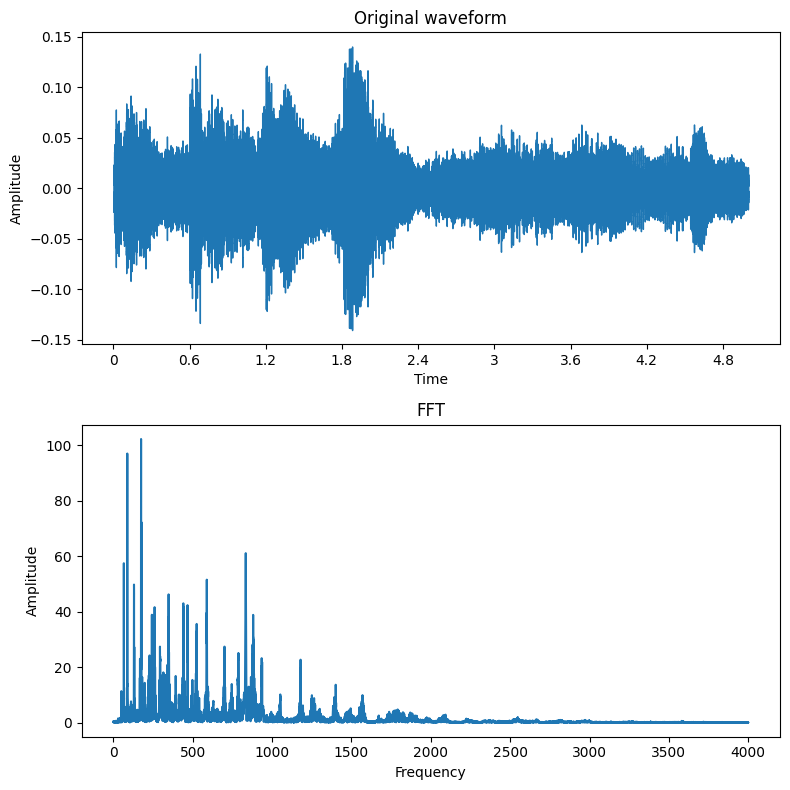

In [40]:
def plot_fft(sample, sr, ax:plt.Axes):
    y = 1/len(sample) * np.abs(np.fft.fft(sample))[:len(sample)//2]
    y = np.abs(np.fft.fft(sample))[:len(sample)//2]
    x = np.linspace(0.0,sr/2.0,len(sample)//2)
    ax.plot(x,y)

fig, axes = plt.subplots(2,1,figsize=(8,8))
librosa.display.waveshow(y=samples2.numpy(),sr=SAMPLING_RATE,ax=axes[0])
axes[0].set_title("Original waveform")
axes[0].set_ylabel("Amplitude")

plot_fft(samples2[0].numpy(),SAMPLING_RATE,axes[1])
axes[1].set_title("FFT")
axes[1].set_ylabel("Amplitude")
axes[1].set_xlabel("Frequency")
fig.tight_layout()
plt.close()
fig

We have amplitude over time in our original data, and the magnitude of each frequency given by FFT, why not use these together?

## Spectogram

Let's try to reduce the problem from an audio classification to image classification

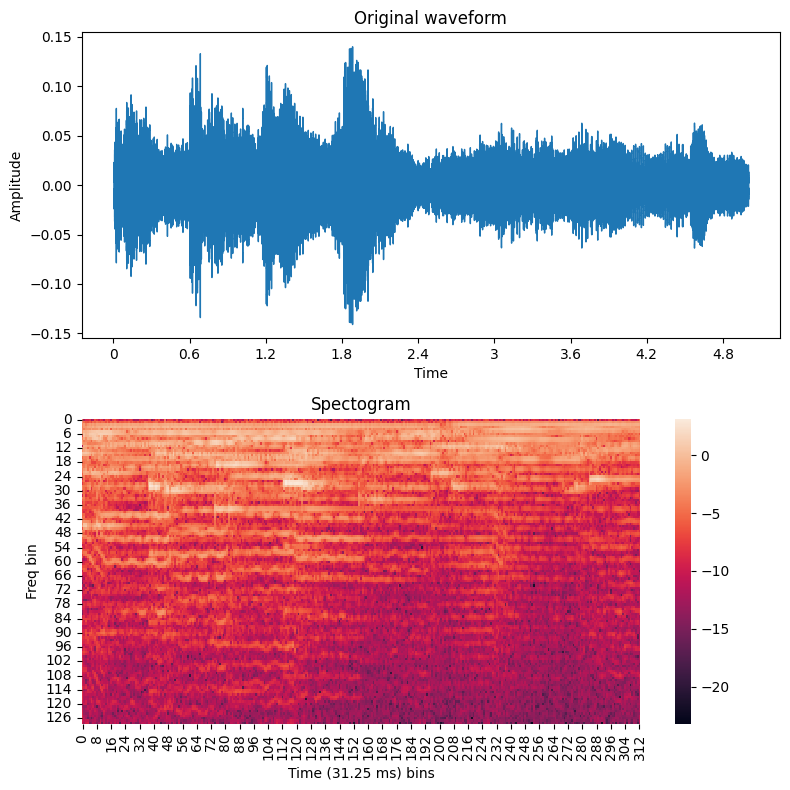

In [41]:
from Dataset import spectrogram as Dataset_spectogram
import torchvision

fig, axes = plt.subplots(2,1,figsize=(8,8))
fig.tight_layout()

#assuming bpm on average to be around ~120 and no note faster than a 64th-note 
#a note should not be shorter than ~31.25 ms
spec = Dataset_spectogram(samples2,SAMPLING_RATE)


librosa.display.waveshow(y=samples2.numpy(),sr=SAMPLING_RATE,ax=axes[0])
axes[0].set_title("Original waveform")
axes[0].set_ylabel("Amplitude")

sns.heatmap(spec[0],ax=axes[1])
axes[1].set_title("Spectogram")
axes[1].set_xlabel("Time (31.25 ms) bins")
axes[1].set_ylabel("Freq bin")
fig.tight_layout()
plt.close()
fig

What if an instrument wasn't played in the interval?

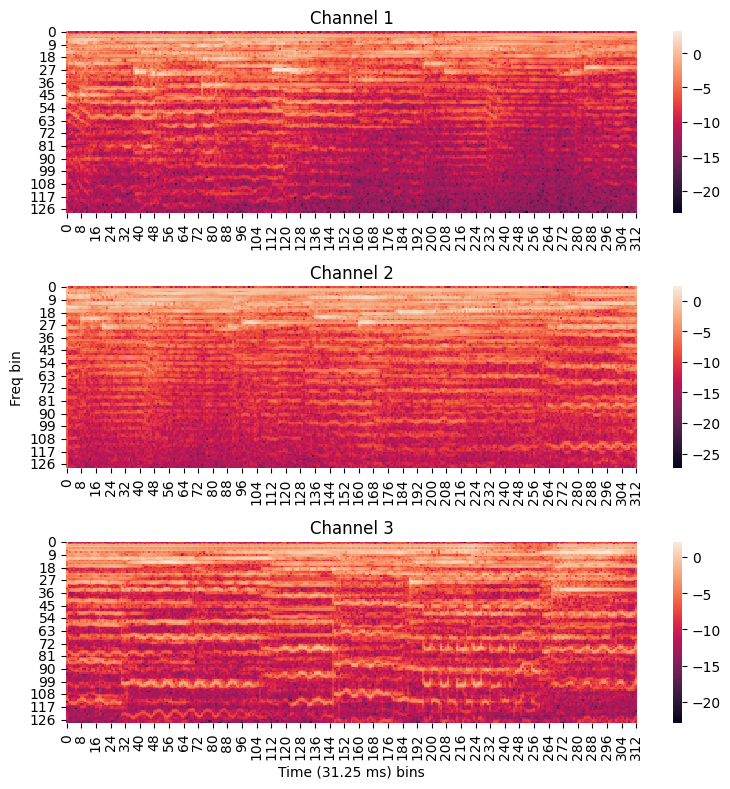

In [42]:
fig, axes = plt.subplots(3,1,figsize=(8,8))
fig.tight_layout()


s,sr = torchaudio.load(AUDIO_EXAMPLE_PATH, frame_offset=(AUDIO_EXAMPLE_OFFSET_SEC+3)*sr1,num_frames=SAMPLE_LENGTH*sr1)
samples3 = torchaudio.functional.resample(s,sr,SAMPLING_RATE)
s,sr = torchaudio.load(AUDIO_EXAMPLE_PATH, frame_offset=(AUDIO_EXAMPLE_OFFSET_SEC+8)*sr1,num_frames=SAMPLE_LENGTH*sr1)
samples4 = torchaudio.functional.resample(s,sr,SAMPLING_RATE)

spec3 = Dataset_spectogram(samples3,SAMPLING_RATE)
spec4 = Dataset_spectogram(samples4,SAMPLING_RATE)


disp = sns.heatmap(spec[0],ax=axes[0])
disp = sns.heatmap(spec3[0],ax=axes[1])
disp = sns.heatmap(spec4[0],ax=axes[2])


axes[0].set_title("Channel 1")
axes[1].set_title("Channel 2")
axes[2].set_title("Channel 3")

axes[2].set_xlabel("Time (31.25 ms) bins")
axes[1].set_ylabel("Freq bin")

fig.tight_layout()
plt.close()
fig

# Training p.t 2

In [46]:
# Mode 1: spectogram + flattening of samples
train_ds,train_loader = get_dataloader(train_x,Y,64,mode=1,cache_size=400)
val_ds, val_loader = get_dataloader(val_x,Y,25,mode=1,cache_size=200)
train_ds[0][0].shape

torch.Size([40377])

### Linear models 

In [47]:
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.multioutput import MultiOutputClassifier
from params import *

composer = Perceptron(n_jobs=-1)
instrument = MultiOutputClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
model1 = SKModel(composer,instrument,withScalar=True)



# composer = SGDClassifier(loss='log_loss',alpha=0.00001,learning_rate='adaptive',eta0=0.0001)
# instrument = MultiOutputClassifier(SGDClassifier(loss='log_loss',alpha=0.00001,learning_rate='adaptive',eta0=0.0001), n_jobs=-1)
# model2 = SKModel(composer,instrument,withScalar=True)


# composer = SGDClassifier(loss='log_loss',alpha=0.000001,learning_rate='adaptive',eta0=0.00001)
# instrument = MultiOutputClassifier(SGDClassifier(loss='log_loss',alpha=0.000001,learning_rate='adaptive',eta0=0.00001), n_jobs=-1)
# model3 = SKModel(composer,instrument,withScalar=True)


# composer = SGDClassifier(loss='hinge',alpha=0.0001)
# instrument = MultiOutputClassifier(SGDClassifier(loss='hinge',alpha=0.0001), n_jobs=-1)
# model4 = SKModel(composer,instrument,withScalar=True)

composer = SGDClassifier(loss='log_loss',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1)
instrument = MultiOutputClassifier(SGDClassifier(loss='hinge',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1), n_jobs=-1)
model2 = SKModel(composer,instrument,withScalar=True)

composer = SGDClassifier(loss='modified_huber',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1)
instrument = MultiOutputClassifier(SGDClassifier(loss='modified_huber',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1), n_jobs=-1)
model3 = SKModel(composer,instrument,withScalar=True)




models2 = [model1,model2,model3]

In [48]:
models2, hist_comp2, hist_inst2, hist_models2 = train_loop(models2,train_loader,val_loader,epoches=EPOCHS)

EPOCH 0
epoch time: 16.529800176620483
train model 0:
exact match: 9.72%    accuracy composer: 32.86%    exact accuracy instrument: 18.55%
combined accuracy: 52.84%    accuracy instrument: 72.81% ->  ['66.25%', '84.28%', '74.91%', '78.45%', '62.37%', '66.43%', '74.91%', '72.61%', '75.09%', '72.79%']
train model 1:
exact match: 18.02%    accuracy composer: 43.99%    exact accuracy instrument: 27.39%
combined accuracy: 61.04%    accuracy instrument: 78.09% ->  ['76.50%', '88.52%', '84.10%', '90.46%', '67.84%', '73.50%', '73.32%', '76.15%', '76.33%', '74.20%']
train model 2:
exact match: 13.78%    accuracy composer: 41.70%    exact accuracy instrument: 22.44%
combined accuracy: 58.75%    accuracy instrument: 75.81% ->  ['77.21%', '87.81%', '72.79%', '87.99%', '61.84%', '70.85%', '74.03%', '73.50%', '77.21%', '74.91%']

val model 0:
exact match: 15.48%    accuracy composer: 45.95%    exact accuracy instrument: 25.00%
combined accuracy: 62.21%    accuracy instrument: 78.48% ->  ['73.81%', '

### CNN


In [43]:
# mode 2 keeps the spectogram as an image. we also load up to 200 samples onto the gpu

train_ds,train_loader = get_dataloader(train_x,Y,64,mode=2,device=DEVICE,cache_size=200)
val_ds, val_loader = get_dataloader(val_x,Y,25,mode=2,device=DEVICE,cache_size=100)
train_ds[0][0].shape

torch.Size([4, 128, 312])

In [44]:
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
import torch


model_composer = nn.Sequential(
    nn.Conv2d(N_CHANNELS,32,(3,7),stride=(1,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,32,(3,5),stride=(2,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),

    #nn.Conv2d(64,64,(3,3),stride=1,padding="same"),
    #nn.ReLU(),
    #nn.BatchNorm2d(64),
    
    nn.Conv2d(64,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),

    nn.Conv2d(64,128,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(128),

    #nn.Conv2d(128,128,(3,3),stride=1,padding="same"),
    #nn.ReLU(),
    #nn.BatchNorm2d(128),
    
    nn.Flatten(),
    nn.Linear(8*8*128,len(COMPOSER_CLASSES)),
    
)



model_instruments = nn.Sequential(
    nn.Conv2d(N_CHANNELS,32,(3,7),stride=(1,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,32,(3,5),stride=(2,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),
    
    nn.Conv2d(64,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),

    nn.Conv2d(64,128,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(128),
    
    nn.Flatten(),
    nn.Linear(8*8*128,len(INSTRUMENT_CLASSES)),
    
)
opt_composer = torch.optim.Adam(model_composer.parameters(),lr=COMPOSER_LEARNING_RATE,betas=(BETA1,BETA2))
opt_instrument = torch.optim.Adam(model_instruments.parameters(),lr=INSTRUMENT_LEARNING_RATE,betas=(BETA1,BETA2))

#### training loop

In [45]:
from torch.functional import F
import torch

def check_accuracy(model_composer,model_instruments, data_loader, name="",verbose=2):
	num_correct_1 = 0
	num_correct_2 = torch.zeros(len(INSTRUMENT_CLASSES),device=DEVICE)
	num_correct_3 = 0
	num_correct_4 = 0

	num_samples = 0
	
	model_composer.eval()  # set model to evaluation mode
	model_instruments.eval()
	
	with torch.no_grad():
		for x, y in data_loader:
			
			y1 = y[0].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			y2 = y[1].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			
			comp_scores = model_composer(x)
			inst_scores = model_instruments(x)

			comp_pred = torch.argmax(nn.Softmax(dim=1)(comp_scores),1)
		
			inst_pred = nn.Sigmoid()(inst_scores) > 0.5
			
			num_correct_1 += torch.sum(comp_pred==y1)
			num_correct_2 += torch.sum(inst_pred == (y2>0.5),0)
			num_correct_3 += torch.sum(torch.prod(inst_pred == (y2>0.5),1))
			correct_1 = comp_pred==y1
			correct_2 = torch.prod(inst_pred == (y2>0.5),1) == 1
			num_correct_4 += torch.sum(correct_1 * correct_2)
			
			num_samples += len(x)

			
			
	comp_accuracy = (num_correct_1/num_samples).cpu().numpy()
	inst_accuracies = (num_correct_2/num_samples).cpu().numpy()
	inst_exact_accuracy = (num_correct_3/num_samples).cpu().numpy()
	exact_accuracy = (num_correct_4/num_samples).cpu().numpy()
	overall_accuracy = ((comp_accuracy + np.mean(inst_accuracies))/2)

	
	if verbose > 0:
		printPerformance(comp_accuracy, inst_accuracies, inst_exact_accuracy, exact_accuracy, overall_accuracy, level=verbose,name = name)
	return  comp_accuracy, inst_accuracies, inst_exact_accuracy, exact_accuracy, overall_accuracy



def train_nn(model_composer:nn.Sequential, model_instruments:nn.Sequential,
		  loader_train, loader_val,
		  optimizer_comp:torch.optim, optimizer_inst:torch.optim,
		  lossFunction_comp=F.cross_entropy, lossFunction_inst=F.multilabel_soft_margin_loss, 
		  verbose = 0,save_checkpoints=None,eval_every=EVAL_EVERY, epoches=EPOCHS):
	
	hist_comp = {"train_loss":{},"train_accuracy":{},"val_accuracy":{}}
	hist_inst= {"train_loss":{},"train_accuracy":{},"val_accuracy":{},"train_accuracy_exact":{},"val_accuracy_exact":{}}
	hist_model = {"train_accuracy":{},"val_accuracy":{},"train_accuracy_exact":{},"val_accuracy_exact":{}}
	model_composer = model_composer.to(device=DEVICE)
	model_instruments = model_instruments.to(device=DEVICE)
	for e in range(epoches):
		if verbose > 0:
			print('EPOCH %d' % (e))
			
		start = time.time()
		for i, (x, y) in enumerate(loader_train):

			model_composer.train()  # put model to training mode
			model_instruments.train()  # put model to training mode
			
			optimizer_comp.zero_grad()
			optimizer_inst.zero_grad()
			
			#x = x.to(device=DEVICE,dtype=torch.float32)  # move to device, e.g. GPU
			comp_scores = model_composer(x)
			inst_scores = model_instruments(x)
			
			y1 = y[0].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			y2 = y[1].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			comp_loss = lossFunction_comp(comp_scores,y1)
			inst_loss = lossFunction_inst(inst_scores,y2)

			comp_loss.backward()
			inst_loss.backward()
			
			hist_comp["train_loss"][e] = comp_loss.item()
			hist_inst["train_loss"][e] = inst_loss.item()

			optimizer_comp.step()
			optimizer_inst.step()
			

		if verbose > 0:
			print("epoch time:",time.time()-start)
		
		if verbose > 0:
			new_verb = verbose + int(e%eval_every == 0 or e==epoches-1) - 2
			acc1,acc2,acc3,acc4,acc5 = check_accuracy(model_composer,model_instruments,loader_train,"train",verbose=new_verb)
			if verbose > 2:
				print('composer model loss: = %.4f, instrument model loss:  %.4f' % (comp_loss.item(), inst_loss.item()))
			hist_comp["train_accuracy"][e]=acc1
			hist_inst["train_accuracy"][e]=acc2
			hist_inst["train_accuracy_exact"][e] = acc3
			hist_model["train_accuracy_exact"][e] = acc4
			hist_model["train_accuracy"][e] = acc5

		if verbose>0 and (e%eval_every == 0 or e==epoches-1):
			acc1,acc2,acc3,acc4,acc5  = check_accuracy(model_composer,model_instruments,loader_val,"val",verbose=verbose-1)
			if verbose > 1:
				print("----------------------------------------------")
				print("")
				print("")
			hist_comp["val_accuracy"][e]=acc1
			hist_inst["val_accuracy"][e]=acc2
			hist_inst["val_accuracy_exact"][e] = acc3
			hist_model["val_accuracy_exact"][e] = acc4
			hist_model["val_accuracy"][e] = acc5

			if save_checkpoints != None:
				torch.save(model_composer,"checkpoints/composer/"+save_checkpoints+str(e)+".pth")
				torch.save(model_instruments,"checkpoints/instrument/"+save_checkpoints+str(e)+".pth")

	return model_composer, model_instruments, hist_comp, hist_inst, hist_model

#### fitting

In [48]:
model_composer, model_instruments, hist_comp3, hist_inst3, hist_models3 = train_nn(model_composer,model_instruments,train_loader,val_loader,opt_composer,opt_instrument,verbose=4,save_checkpoints="first",eval_every=EVAL_EVERY,epoches=EPOCHS)

EPOCH 0
epoch time: 2.879499673843384
train:
exact match: 13.02%    accuracy composer: 26.67%    exact accuracy instrument: 32.70%
combined accuracy: 54.64%    accuracy instrument: 82.62% ->  ['70.00%', '85.56%', '84.44%', '84.92%', '76.83%', '89.52%', '84.29%', '84.76%', '79.68%', '86.19%']
composer model loss: = 1.3713, instrument model loss:  0.3552
val:
exact match: 12.14%    accuracy composer: 23.33%    exact accuracy instrument: 33.81%
combined accuracy: 53.14%    accuracy instrument: 82.95% ->  ['70.00%', '82.62%', '84.05%', '81.19%', '75.00%', '89.29%', '88.33%', '86.67%', '84.52%', '87.86%']
----------------------------------------------


EPOCH 1
epoch time: 2.823000192642212
train:
exact match: 13.33%    accuracy composer: 31.59%    exact accuracy instrument: 39.84%
combined accuracy: 58.94%    accuracy instrument: 86.30% ->  ['76.67%', '89.37%', '86.35%', '89.68%', '77.78%', '90.48%', '89.05%', '88.41%', '86.83%', '88.41%']
composer model loss: = 1.2459, instrument model lo

# Evaluation
Let's compare the online models and finally choose the best one to use for our testing data

## Model performances during training
### Overall performance
Let's see how well the models performed across both instrument classification and composer at the same time

In [168]:
def plot_models_accuracy_together(hist1,hist2,hist3,axes,train_key = "train_accuracy",val_key="val_accuracy"):
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:pink']
    for i, hist in enumerate(hist1):
        axes[0].plot(hist[train_key].keys(),hist[train_key].values(),color=colors[i])
        axes[1].plot(hist[val_key].keys(),hist[val_key].values(),color=colors[i],label=f"models1 {i}")


    for i, hist in enumerate(hist2):
        axes[0].plot(hist[train_key].keys(),hist[train_key].values(),'--',color=colors[i])
        axes[1].plot(hist[val_key].keys(),hist[val_key].values(),'--',color=colors[i],label=f"models2 {i}")


    axes[0].plot(hist3[train_key].keys(),hist3[train_key].values(),color='g')
    axes[1].plot(hist3[val_key].keys(),hist3[val_key].values(),color='g',label="cnn model")

    axes[0].set_title("Train accuracy")
    axes[1].set_title("Validation accuracy")
    axes[0].set_ylabel("accuracy")

    axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    return axes
from matplotlib.gridspec import GridSpec

def plot_models_accuracy(hist1,hist2,hist3,title="", train_key="train_accuracy",val_key="val_accuracy"):
    fig = plt.figure(figsize=(len(hist1)*3.9,2.3*4))
    gs = GridSpec(4, len(hist1)*2, figure=fig)

    ax1 = fig.add_subplot(gs[0, :len(hist1)])
    ax1.tick_params(labelbottom = False, bottom = False) 
    ax2 = fig.add_subplot(gs[0, len(hist1):],sharey=ax1)
    ax2.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False) 
    plot_models_accuracy_together(hist1,hist2,hist3,[ax1,ax2],train_key = train_key,val_key=val_key)
    
    
    axes = []
    for i in range(len(hist1)):
        if i == 0:
            axes.append(fig.add_subplot(gs[1, 2*i:2*i + 2]))
            axes[i].tick_params(labelbottom = False, bottom = False) 
        else:
            axes.append(fig.add_subplot(gs[1, 2*i:2*i + 2],sharey=axes[-1]))
            axes[i].tick_params(left = False, labelleft = False , labelbottom = False, bottom = False) 
    for i, hist in enumerate(hist1):
        axes[i].plot(hist[train_key].keys(),hist[train_key].values(),label=f"train")
        axes[i].plot(hist[val_key].keys(),hist[val_key].values(),'--',label=f"val")
        axes[i].set_title(f"models1 {i}")
        
    axes[-1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    axes[0].set_ylabel("accuracy")

    axes2 = []
    for i in range(len(hist1)):
        if i == 0:
            axes2.append(fig.add_subplot(gs[2, 2*i:2*i + 2],sharex=axes[i]))
            axes2[i].tick_params(labelbottom = False, bottom = False) 
        else:
            axes2.append(fig.add_subplot(gs[2, 2*i:2*i + 2],sharex=axes[i],sharey=axes2[-1]))
            axes2[i].tick_params(left = False, labelleft = False , labelbottom = False, bottom = False) 

    for i, hist in enumerate(hist2):
        axes2[i].plot(hist[train_key].keys(),hist[train_key].values(),label=f"train")
        axes2[i].plot(hist[val_key].keys(),hist[val_key].values(),'--',label=f"val")
        axes2[i].set_title(f"models2 {i}")
    axes2[-1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    axes2[0].set_ylabel("accuracy")

    ax = fig.add_subplot(gs[3, :])
    ax.plot(hist3[train_key].keys(),hist3[train_key].values(),label="train")
    ax.plot(hist3[val_key].keys(),hist3[val_key].values(),'--',label="val")
    ax.set_title(f"cnn model")

    ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    ax.set_ylabel("accuracy")
    ax.set_xlabel("epoch")

    fig.suptitle(title)
    fig.tight_layout()
    plt.close()
    return fig

    


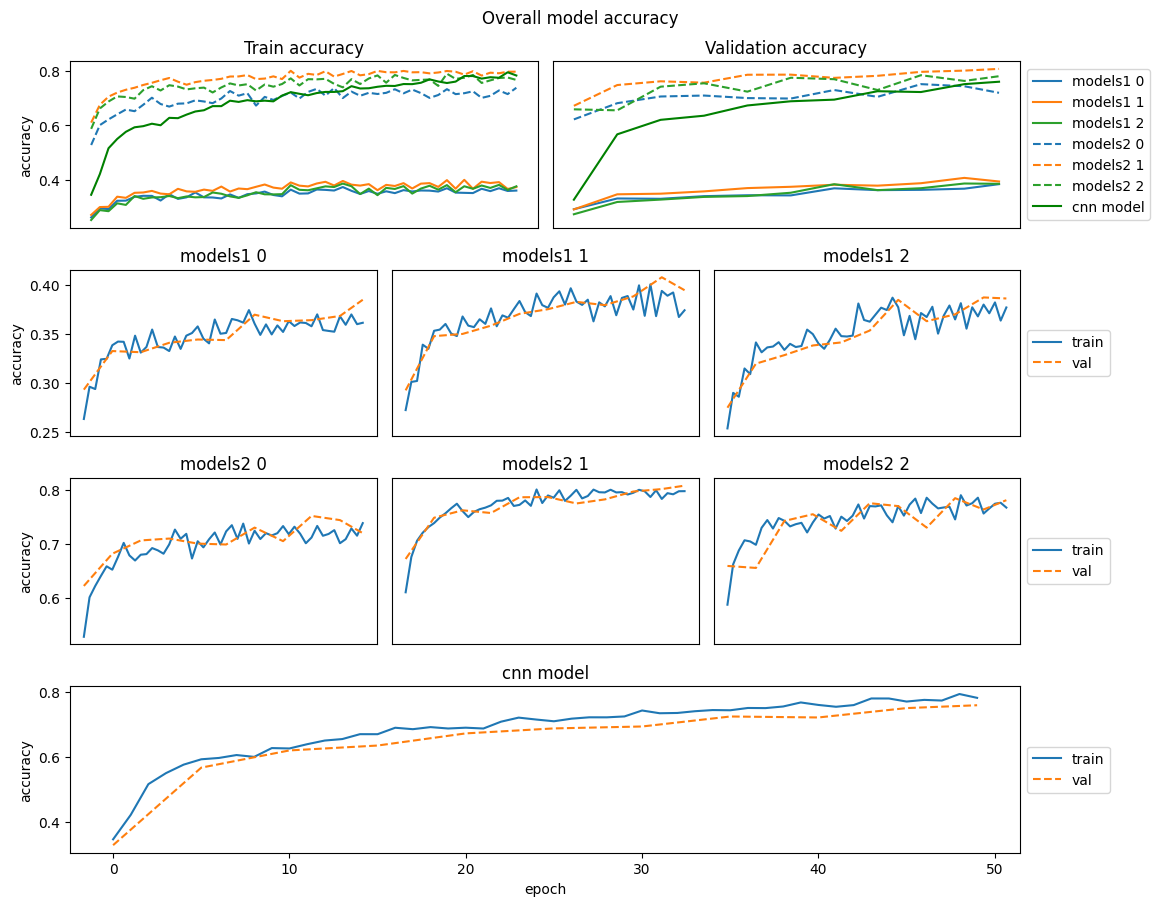

In [ ]:
plot_models_accuracy(hist_models1,hist_models2,hist_models3,"Overall model accuracy")

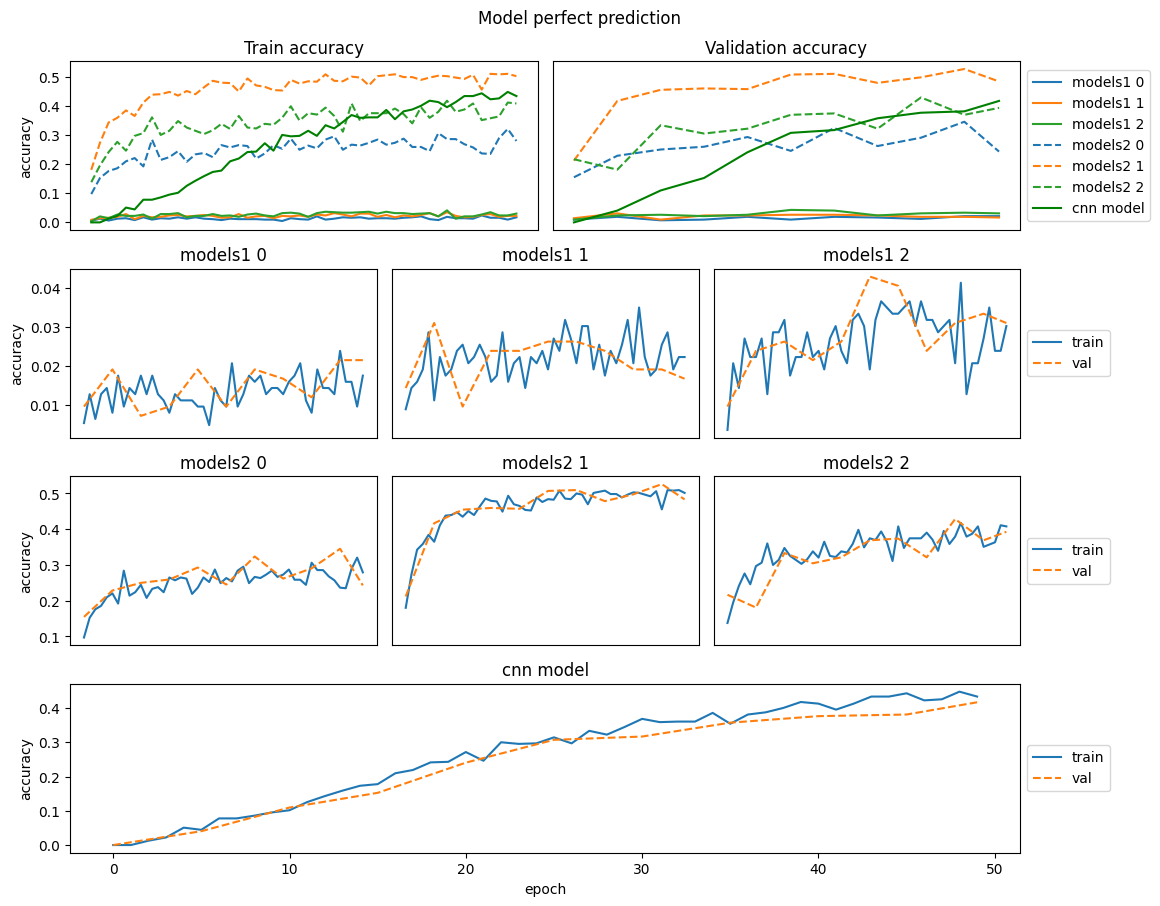

In [ ]:
plot_models_accuracy(hist_models1,hist_models2,hist_models3,train_key="train_accuracy_exact",val_key="val_accuracy_exact",title="Model perfect prediction")

### Composer classification performance
Now let's review the models capabilities to classify composers alone

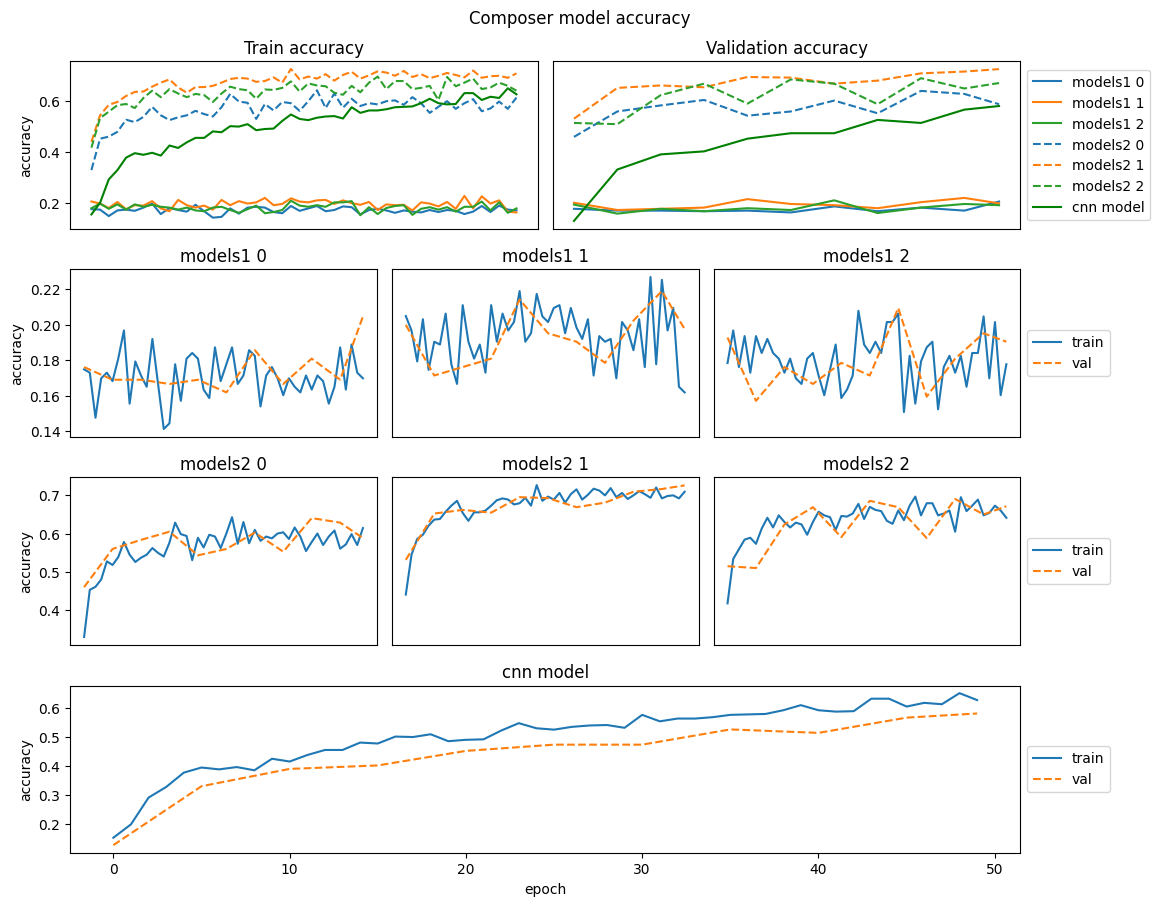

In [ ]:
plot_models_accuracy(hist_comp1,hist_comp2,hist_comp3,title="Composer model accuracy")

We can clearly see that transforming the audio data into a spectogram greatly increased the models performance, it seems that given more epoches, a linear model might come close to the CNN

### Instrument classification performance

First we will look at how good the model is in classifying each instrument alone, then look at how good the model is at perfectly classifying all instruments

In [ ]:
def plot_hist_inst(hist,axes,color='g', name=""):
    def get_arr_data(hist):
        accs = []
        for acc in hist.values():
            if type(acc) == torch.Tensor:
                accs.append(acc.numpy())
            else:
                accs.append(acc)
        
        return np.array(accs)

    train_accs = get_arr_data(hist["train_accuracy"])
    val_accs = get_arr_data(hist["val_accuracy"])
    for i in range(train_accs.shape[1]):
        
        axes[i%len(axes), i//len(axes)].plot(hist["train_accuracy"].keys(),train_accs[:,i],label = f"{name} train",color=color)
        axes[i%len(axes), i//len(axes)].plot(hist["val_accuracy"].keys(),val_accs[:,i],'--',label=f"{name} val",color=color)
        axes[i%len(axes), i//len(axes)].set_title(f"instrument {i}")
       


# class InstClassGraph:
    
#     def __init__(self,inst_hists,titles):
#         self.inst_hists = inst_hists
#         self.titles = titles
#         self.ind = 0
        
#         self.colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:pink']


#     def load_graph(self,event:mpl.Event):
#         hists = self.inst_hists[self.ind%len(self.inst_hists)]
#         axes = np.array(event.canvas.figure.axes)[:-2]
#         for ax in axes:
#             ax.clear()
#         axes = axes.reshape(5,2)
        
#         if len(hists) > 1:
#             for i,hist in enumerate(hists):
#                 plot_hist_inst(hist,axes,self.colors[i],name=f"model {i}")
#         else:
#             plot_hist_inst(hists[0],axes)
            
#         axes[3,1].legend(loc='center left', bbox_to_anchor=(1,0.5))
#         event.canvas.figure.suptitle(self.titles[self.ind%len(self.inst_hists)])
#         plt.draw()

#     def next(self, event:mpl.Event):
#         print(event)
#         self.ind += 1
#         self.load_graph(event)

#     def prev(self, event:mpl.Event):
#         self.ind -= 1
#         self.load_graph(event)

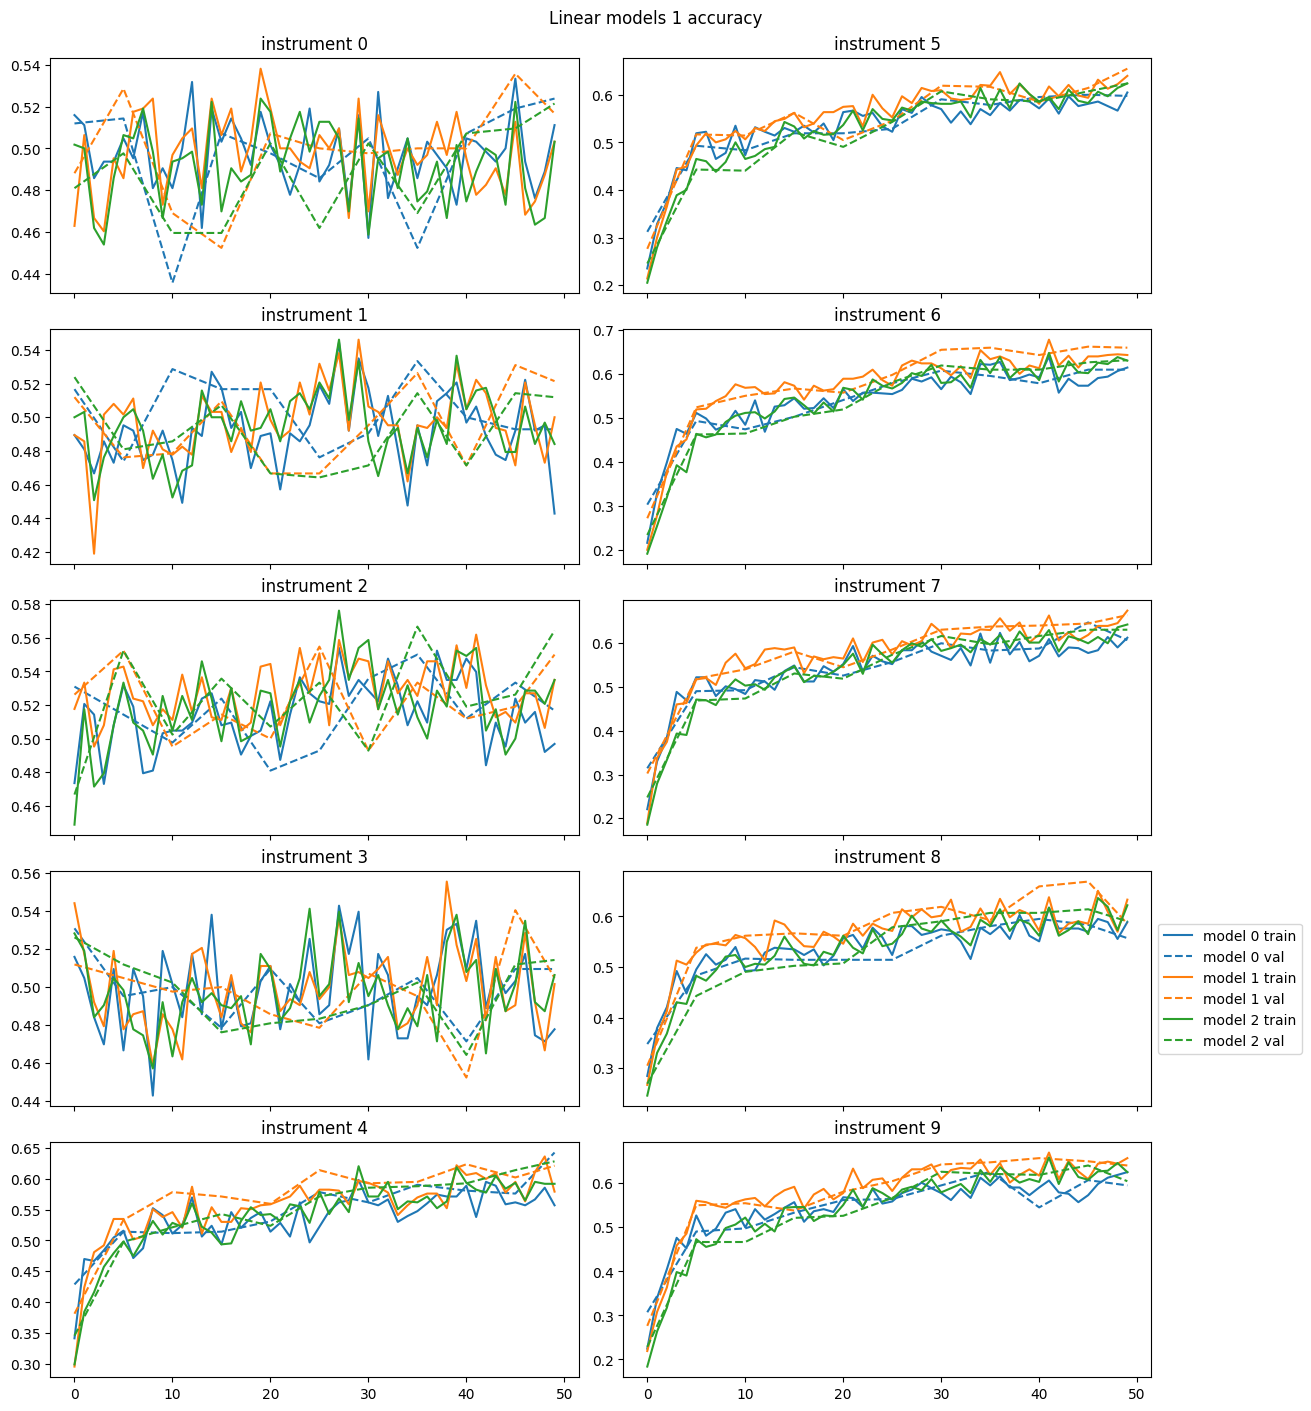

In [ ]:
fig, axes = plt.subplots(5,2,figsize=(13,14),sharex=True,sharey=False,constrained_layout=True)
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:pink']

for i,hist in enumerate(hist_inst1):
    plot_hist_inst(hist,axes,colors[i],name=f"model {i}")
axes[3,1].legend(loc='center left', bbox_to_anchor=(1,0.5))
fig.suptitle("Linear models 1 accuracy")
plt.close()
fig

# from matplotlib.widgets import Button
# axprev = fig.add_axes([0.85, 0.05, 0.05, 0.075])
# axnext = fig.add_axes([0.91, 0.05, 0.05, 0.075])

# callback = InstClassGraph([hist_inst1,hist_inst2,[hist_inst3]],titles=["Linear models 1 accuracy","Linear models 2 accuracy","CNN model accuracy"])

# bnext = Button(axnext, 'Next')
# bnext.on_clicked(callback.next)
# bprev = Button(axprev, 'Previous')
# bprev.on_clicked(callback.prev)



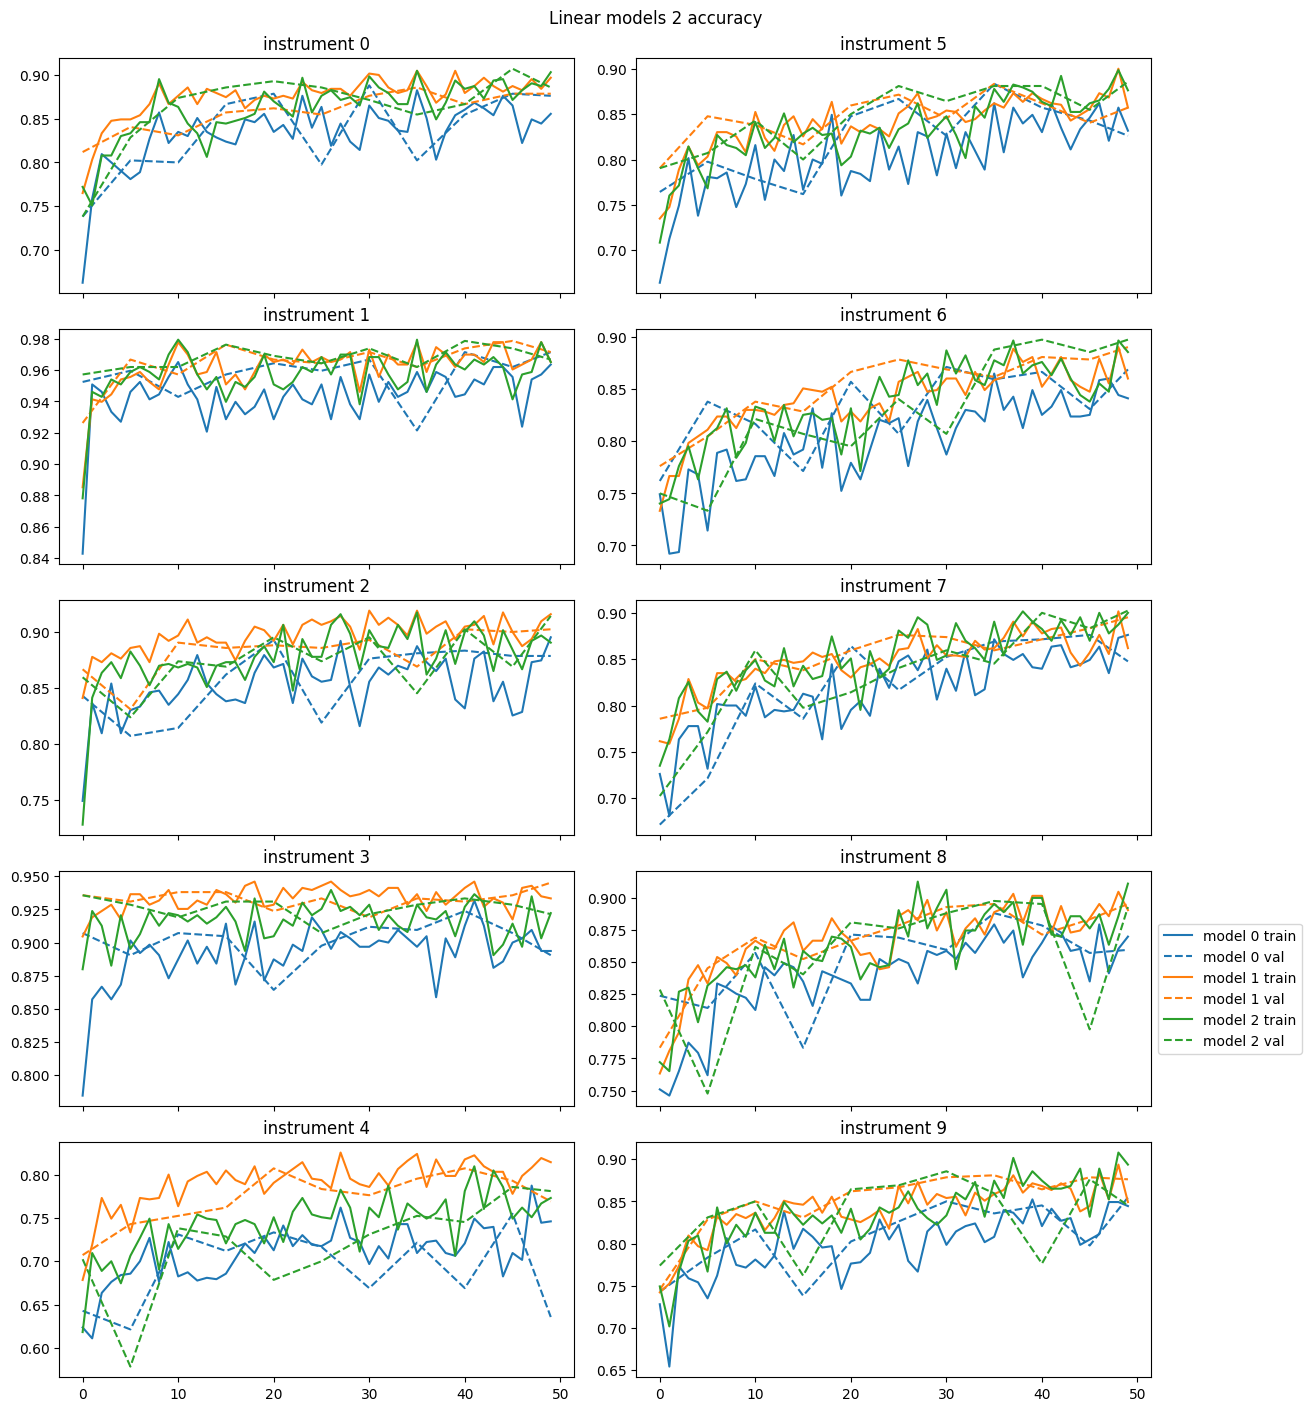

In [ ]:
fig, axes = plt.subplots(5,2,figsize=(13,14),sharex=True,sharey=False,constrained_layout=True)
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:pink']

for i,hist in enumerate(hist_inst2):
    plot_hist_inst(hist,axes,colors[i],name=f"model {i}")
axes[3,1].legend(loc='center left', bbox_to_anchor=(1,0.5))
fig.suptitle("Linear models 2 accuracy")
plt.close()
fig

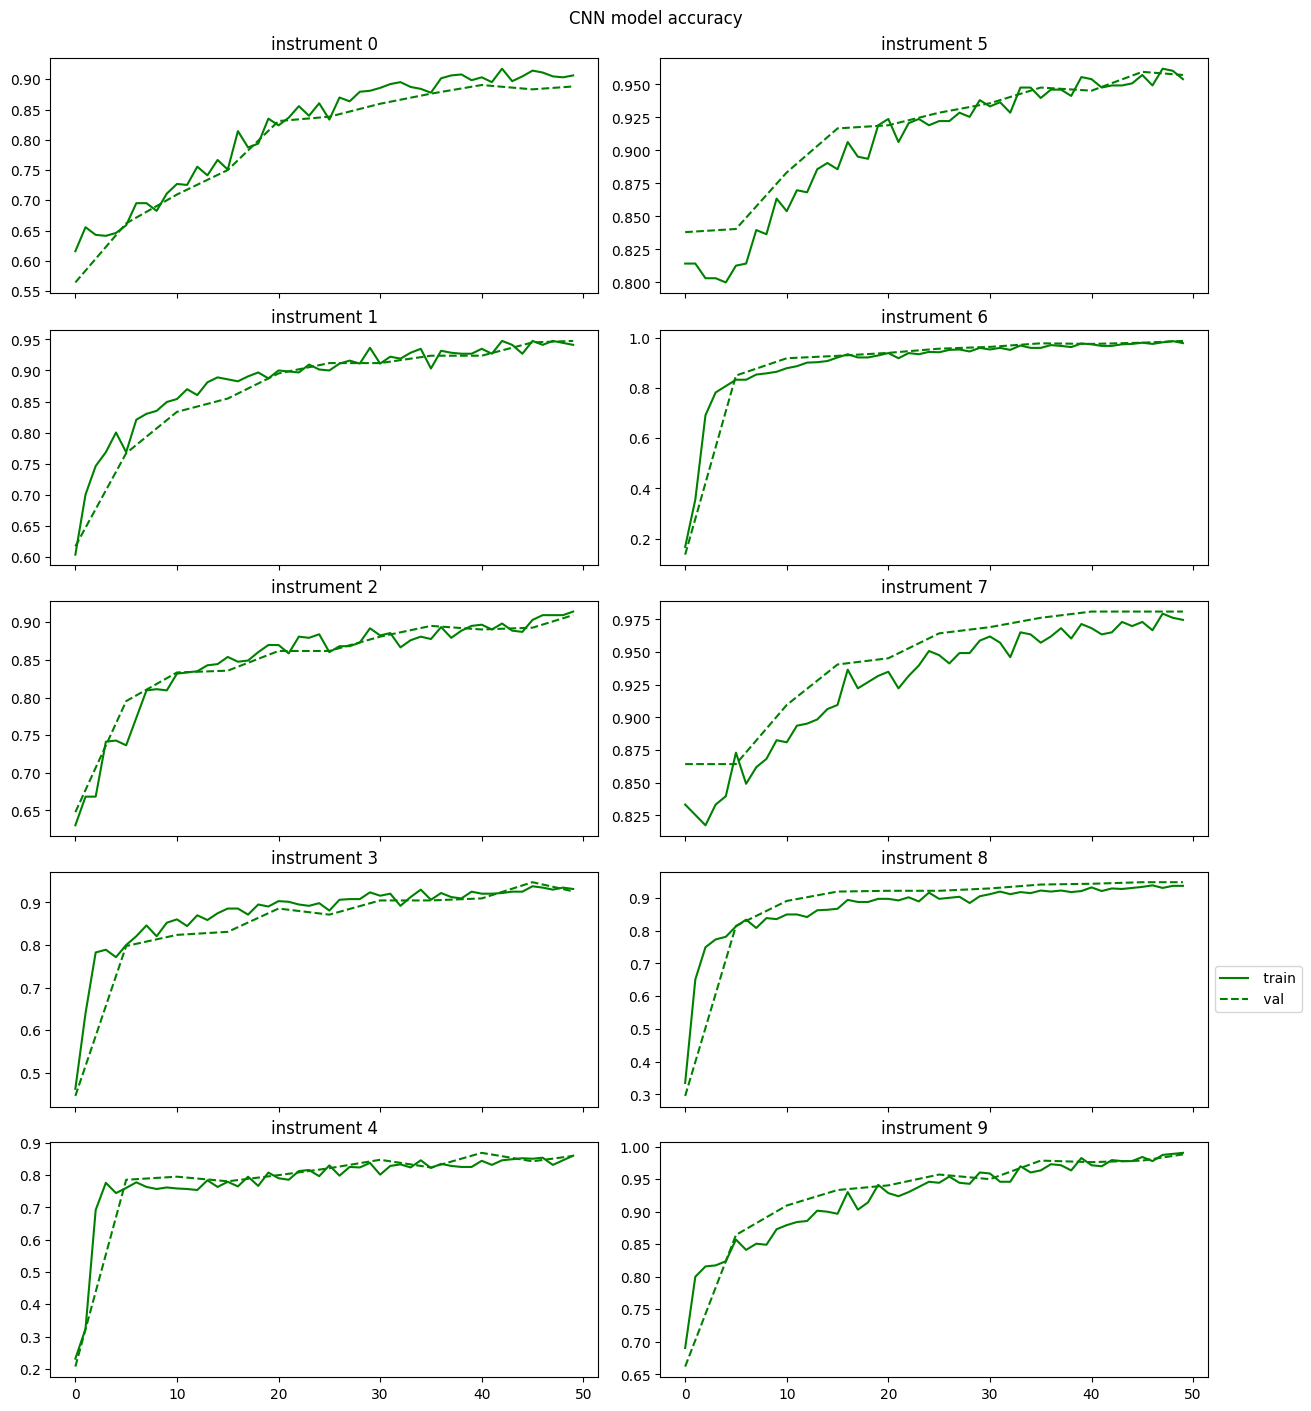

In [ ]:
fig, axes = plt.subplots(5,2,figsize=(13,14),sharex=True,sharey=False,constrained_layout=True)

plot_hist_inst(hist_inst3,axes)
axes[3,1].legend(loc='center left', bbox_to_anchor=(1,0.5))

fig.suptitle("CNN model accuracy")
plt.close()
fig

Let's see how many times the instrument models managed to perfectly classify all instruments

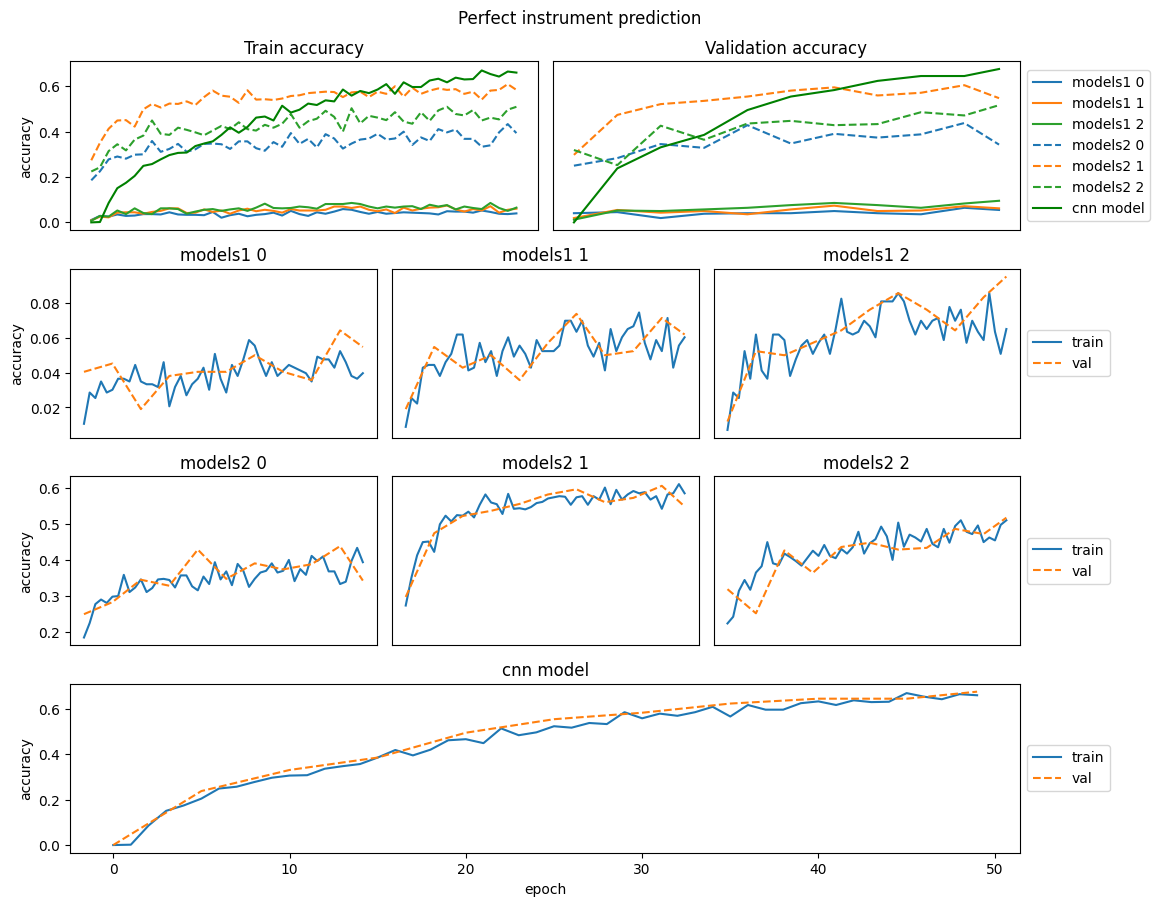

In [ ]:
plot_models_accuracy(hist_inst1,hist_inst2,hist_inst3,train_key="train_accuracy_exact",val_key="val_accuracy_exact",title="Perfect instrument prediction")

In all the graphs we saw that the CNN model has the smoothest increase in both train and validation. Since the CNN trains at a much faster rate, I will be training it for some more epoches before testing it.

In [ ]:
model_composer, model_instruments, hist_comp4, hist_inst4, hist_models4 = train_nn(model_composer,model_instruments,train_loader,val_loader,opt_composer,opt_instrument,verbose=4,save_checkpoints="second",eval_every=EVAL_EVERY,epoches=EPOCHS)

EPOCH 0
epoch time: 3.2365000247955322
train:
exact match: 45.56%    accuracy composer: 62.54%    exact accuracy instrument: 66.35%
combined accuracy: 78.34%    accuracy instrument: 94.14% ->  ['91.75%', '94.44%', '89.84%', '93.97%', '85.24%', '96.19%', '99.05%', '98.25%', '93.81%', '98.89%']
composer model loss: = 0.9229, instrument model loss:  0.1754
val:
exact match: 40.00%    accuracy composer: 56.43%    exact accuracy instrument: 65.71%
combined accuracy: 75.15%    accuracy instrument: 93.88% ->  ['89.76%', '95.24%', '89.52%', '92.38%', '84.29%', '95.95%', '99.29%', '98.10%', '95.48%', '98.81%']
----------------------------------------------


EPOCH 1
epoch time: 3.0680007934570312
train:
exact match: 47.62%    accuracy composer: 65.56%    exact accuracy instrument: 68.10%
combined accuracy: 79.70%    accuracy instrument: 93.84% ->  ['90.32%', '94.29%', '91.11%', '94.29%', '85.71%', '95.71%', '97.78%', '97.30%', '93.65%', '98.25%']
composer model loss: = 1.1522, instrument model 

In [ ]:
tmp = hist_comp3
def updateHist(hist1,hist2):
    for entry in hist2:
        hist1[entry].update({k+max(hist1[entry].keys()):v for k,v in hist2[entry].items()})

    return hist1

hist_comp = updateHist(hist_comp3,hist_comp4)
hist_inst = updateHist(hist_inst3,hist_inst4)
hist_model = updateHist(hist_models3,hist_models4)


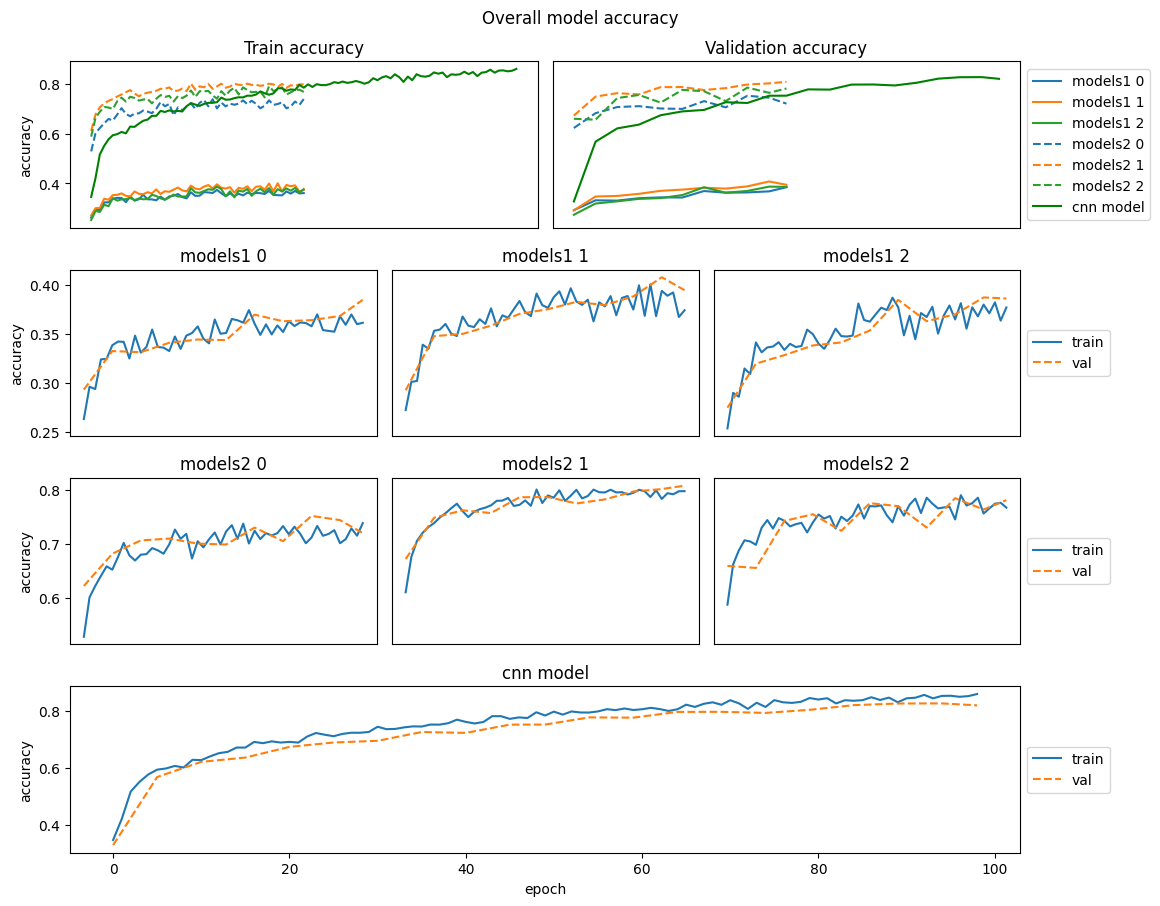

In [ ]:
plot_models_accuracy(hist_models1,hist_models2,hist_models3,"Overall model accuracy")

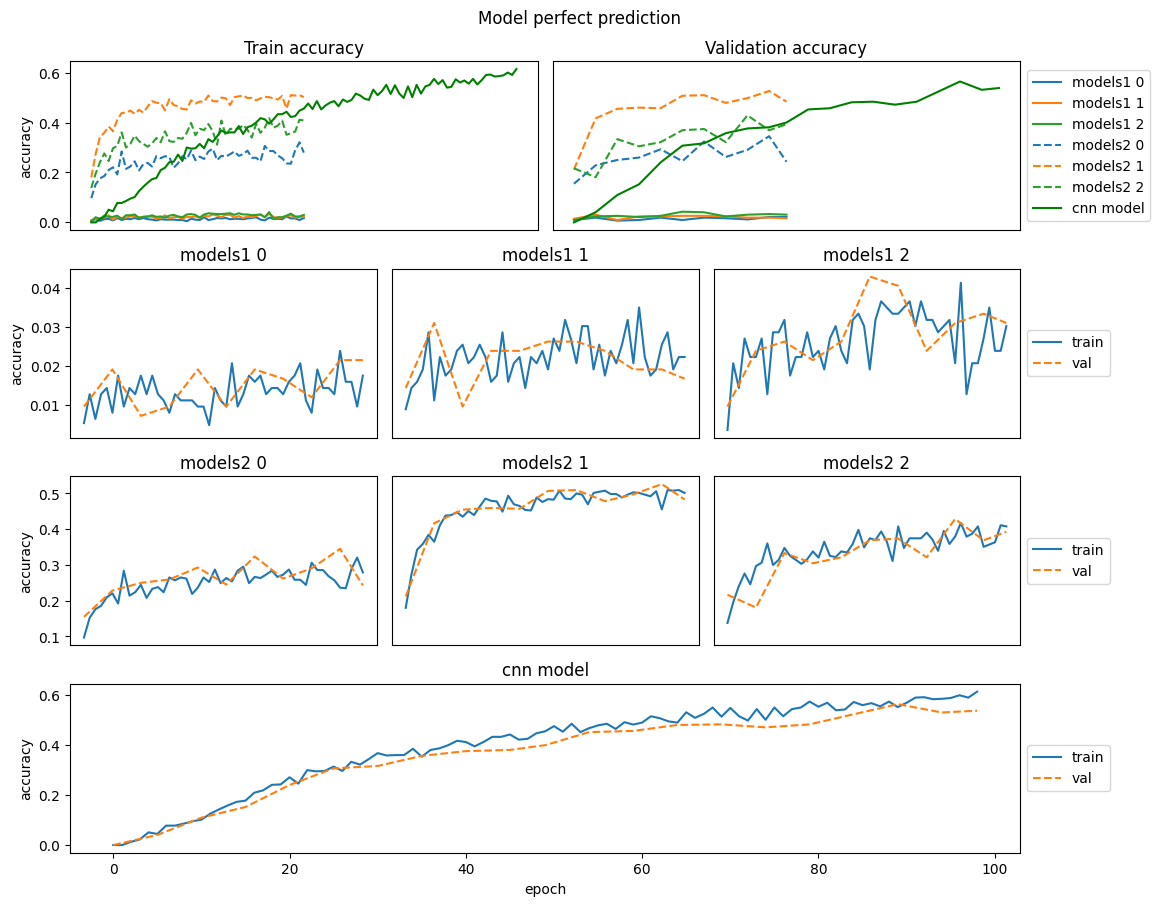

In [ ]:
plot_models_accuracy(hist_models1,hist_models2,hist_models3,train_key="train_accuracy_exact",val_key="val_accuracy_exact",title="Model perfect prediction")

# Test

In [50]:
test_ds,test_loader = get_dataloader(test_x,test_y,25,False,mode=2,device=DEVICE,cache_size=200)
test_x.shape

(38,)

In [59]:
def get_model_preds(model_composer,model_instruments, test_loader, factor = 1):
    comp_pred = []
    inst_pred = []
    test_raw_y1 = []
    test_raw_y2 = []
    with torch.no_grad():
        for i in range(factor):
            for x,y in test_loader:
                comp_scores = model_composer(x)
                inst_scores = model_instruments(x)
                test_raw_y1 = test_raw_y1 + y[0].cpu().tolist()
                test_raw_y2 = test_raw_y2 + y[1].cpu().tolist()
                comp_pred = comp_pred + torch.argmax(nn.Softmax(dim=1)(comp_scores),1).cpu().tolist()
                inst_pred = inst_pred + (1*(nn.Sigmoid()(inst_scores) > 0.5)).cpu().tolist()
    test_raw_y1 = np.array(test_raw_y1)
    test_raw_y2 = np.array(test_raw_y2)
    comp_pred = np.array(comp_pred)
    inst_pred = np.array(inst_pred)
    return test_raw_y1,comp_pred, test_raw_y2, inst_pred


#since our test data is small and each sample may have multiple labels, we iterate over the data multiple times
y_real1, comp_pred, y_real2, inst_pred = get_model_preds(model_composer,model_instruments,test_loader,factor=40)
#notice that 
np.unique(y_real1[::len(test_x)])

array([0])

### Composer classification

In [64]:
print(classification_report(y_real1,comp_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       320
           1       0.73      0.71      0.72       520
           2       0.76      0.84      0.80       200
           3       0.99      1.00      0.99        80
           4       0.21      0.38      0.27        40
           5       0.47      0.73      0.58       200
           6       0.98      0.36      0.53       160

    accuracy                           0.73      1520
   macro avg       0.73      0.69      0.68      1520
weighted avg       0.78      0.73      0.73      1520



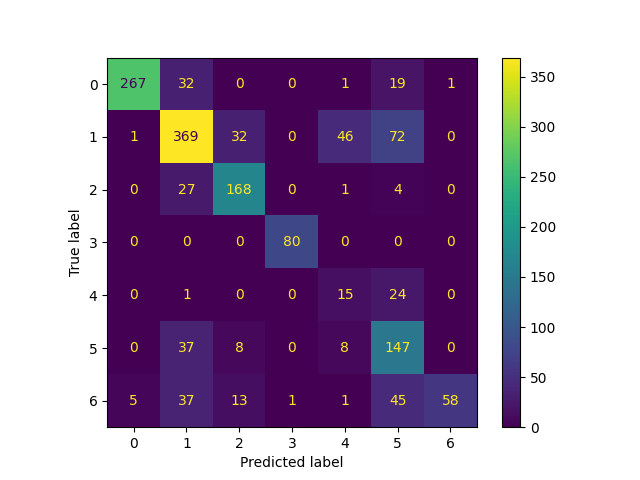

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_real1, comp_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

### Instrument classification

In [66]:
print(classification_report(y_real2,inst_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       680
           1       0.89      0.99      0.94       800
           2       0.75      0.84      0.79       440
           3       0.80      0.94      0.86       720
           4       0.80      0.37      0.51       400
           5       0.97      0.97      0.97       280
           6       0.87      0.87      0.87       120
           7       1.00      0.99      0.99       240
           8       0.95      0.71      0.82       400
           9       0.74      0.97      0.84       120

   micro avg       0.87      0.87      0.87      4200
   macro avg       0.87      0.86      0.85      4200
weighted avg       0.87      0.87      0.86      4200
 samples avg       0.88      0.90      0.87      4200



c:\Users\Ziv\Desktop\University\year_4\Semester_2\machine_learning\project\.conda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


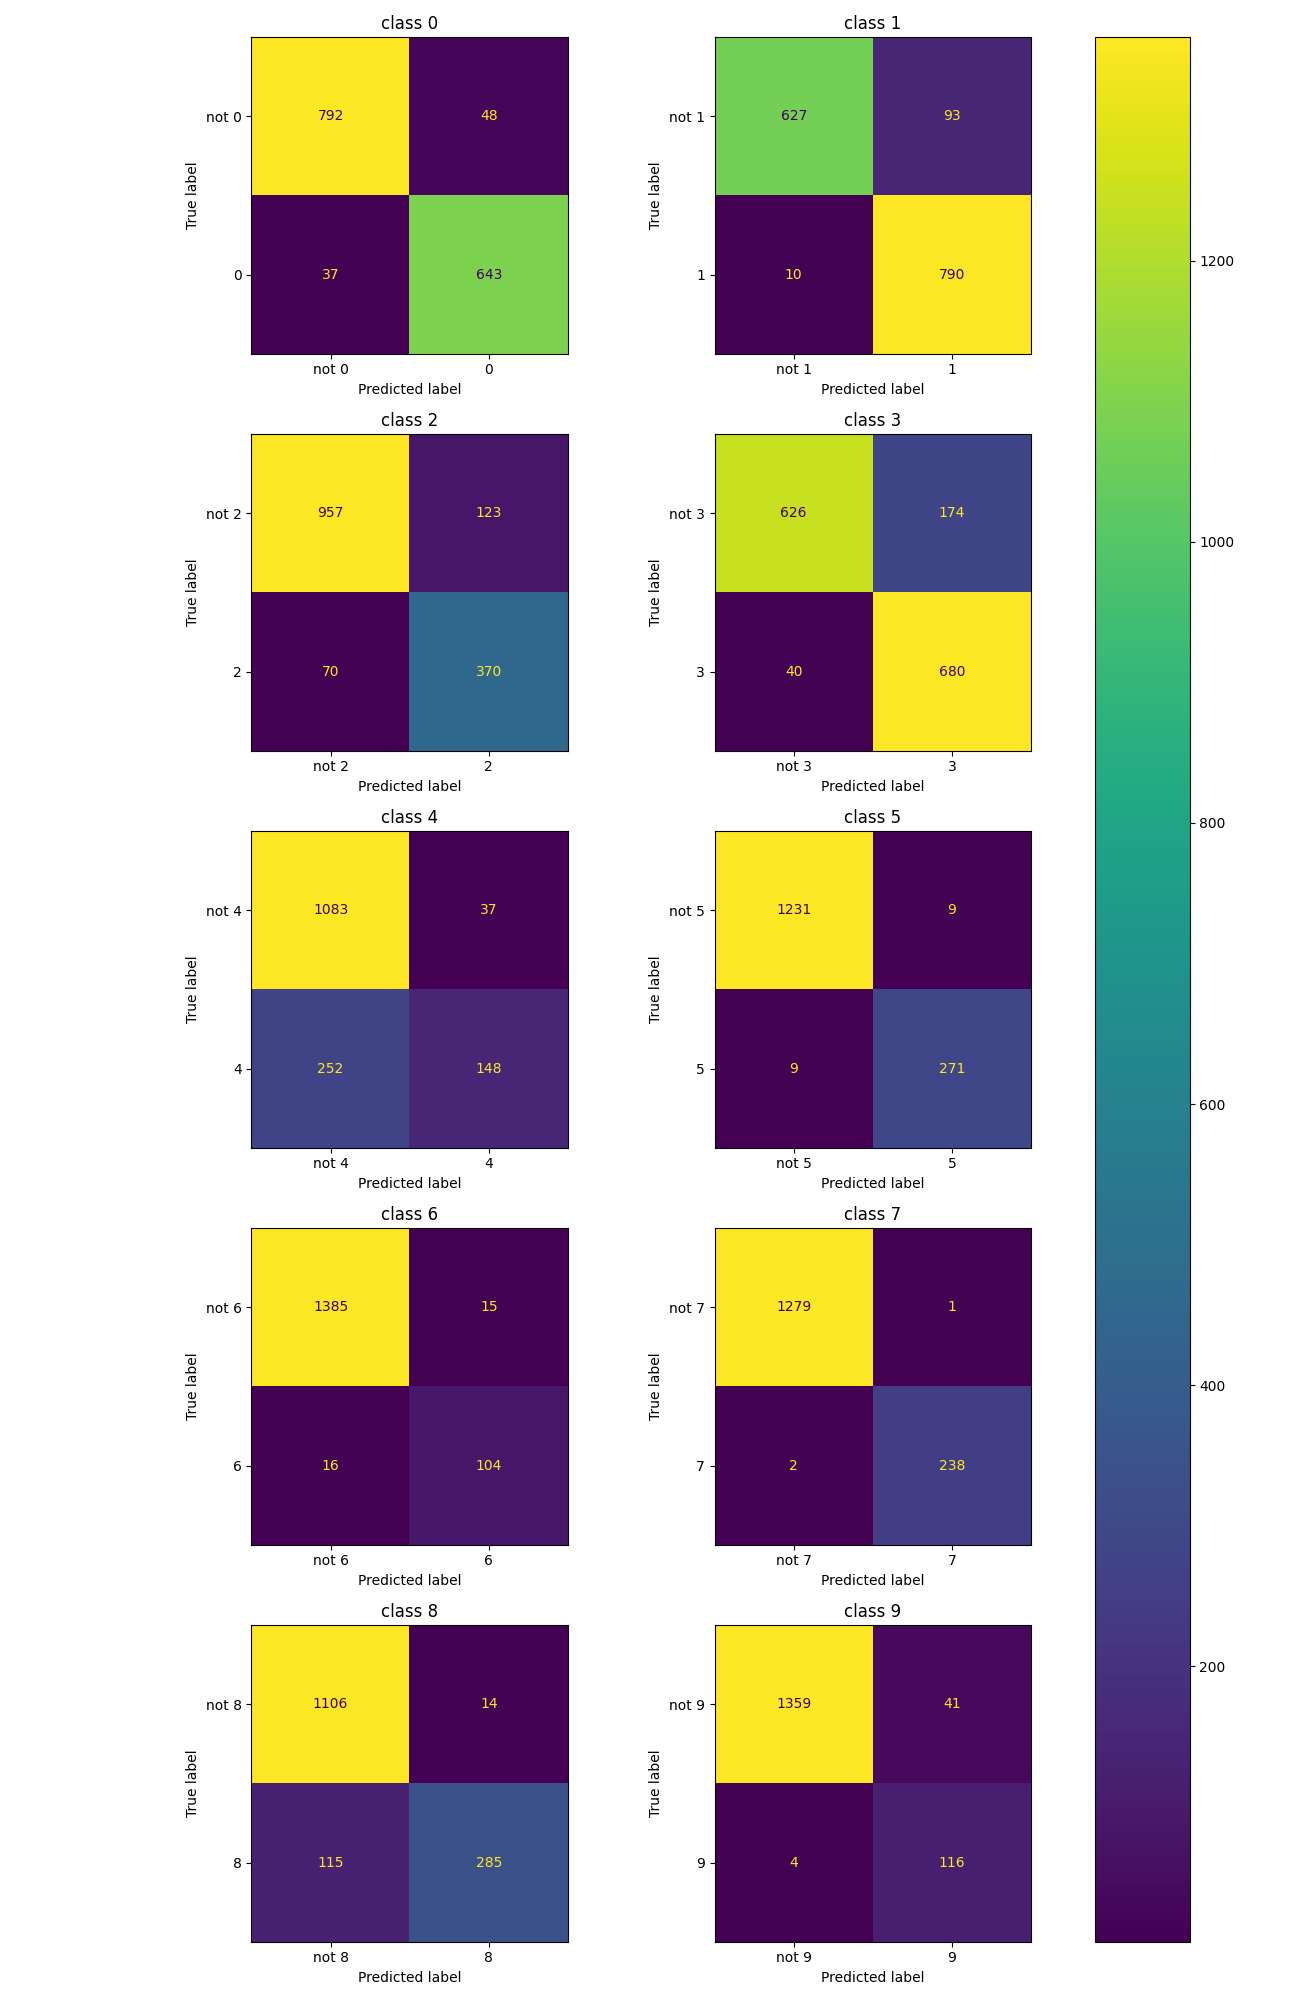

In [67]:
f, axes = plt.subplots(5, 2, figsize=(13,20))
axes = axes.ravel()
y_real2 = np.array(y_real2)
inst_pred = np.array(inst_pred)


for i in range(len(axes)):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_real2[:, i],inst_pred[:, i]),display_labels=[f'not {i}', i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    
    disp.im_.colorbar.remove()

f.tight_layout()
f.colorbar(disp.im_, ax=axes)
plt.show()